# How to measure the overall quality of mobile applications  
## Motivation  
According to Statista.com, current smartphone users are 3.2 billions. It is clear that smartphones have become a part of our lives. We can watch TV shows, news or share our photos to friends or play games anywhere. And these are possible because of many 3rd party applications. You can start a great business by creating a great application because there are many users to use your application. At the same time, there are many applications coming out everyday, which makes the application market very competitive. If there are differences between successful applications and not so successful ones by analyzing application store data and reviews, it will be a great metric to follow to create successful applications.  
## Hypothesis  
- All applications have to be segmented based on the categories before the analysis. This is because every category has different market sizes and types of users; therefore, the standard of being a successful application might be different in each category.   
- Due to the lack of information about marketing spend on each application, it might be difficult to find out the difference in the number of downloads among applications with similar data points. Therefore, the reviews need to be analyzed to see if there is a hint about its marketing strategy.  
- Based on the reviews, users’ satisfaction on specific features and details about what users are expecting from an application can be inferred in each category.  

## Assumptions  
- A successful application: Top 10% of distribution in downloads with 4.0+ rating in its category.  
- There is no difference between IOS users and Android users.   

## Deliverables  
App Developers, Entrepreneurs, UI/UX Designers, Product Managers, or whoever involves in creating a mobile application will benefit from the results of this analysis. It will give ideas about the important factors to create successful applications and the expectations on applications in each category from users. With the results, it will give them which direction they need to pursue to create successful applications. Furthermore, they can have a general idea about how an application will perform in the mobile application market with a machine learning model that predicts the number of downloads and ratings of application based on the factors and reviews.

## Dependencies

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.patches as pat
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from datetime import datetime
from dateutil.parser import parse
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import scale, PolynomialFeatures, Normalizer, MinMaxScaler, power_transform
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.svm import SVR
from xgboost import XGBClassifier
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import Axis, HoverTool
from pandas.plotting import register_matplotlib_converters

plt.style.use('ggplot')
output_notebook()
register_matplotlib_converters()
%matplotlib inline

Loading BokehJS ...

In [2]:
# Load the dataset
table = pd.read_csv('googleplaystore.csv')

## Data Preprocessing

In [3]:
# Glimpse the dataset
table.head()

App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend Play  January 15, 2018               2.0.0   
2               Art & Design    August 1, 2018               1.2.4   
3               Art & Design      June 8, 2018  Varies with device   
4    Art & Design;Creativity     June 20, 2018                 1.1   

    Android Ver  
0  4.0.3 and up  
1  4.0.3 and up  
2  4.0.3 and up  
3    4.2 and up  
4    4.4 and up

> ### Drop 'Size' and 'Current Ver' because these are not meaningful features in this analysis.

In [4]:
table  = table.drop(['App', 'Current Ver'], axis=1)

> ### 'Category' and 'Genres' contain similar information. Let's see if we can drop the one of two columns.

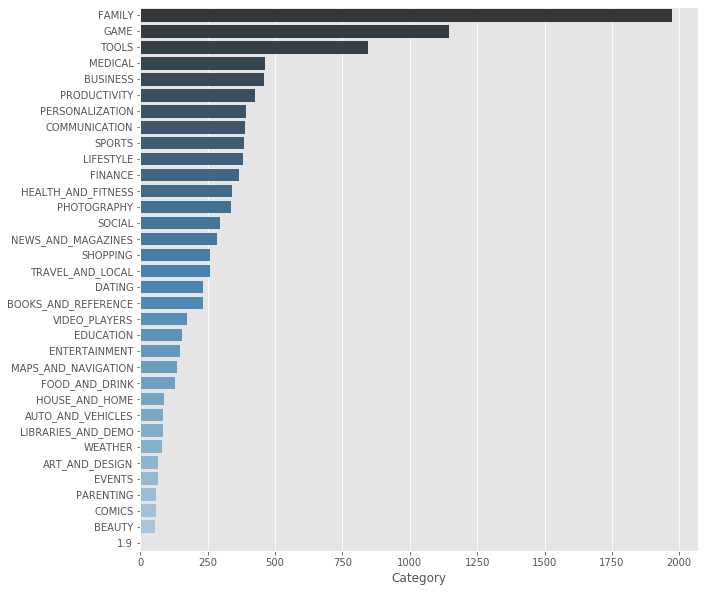

In [5]:
# Count by 'Category'
plt.figure(figsize=(10,10))
sns.barplot(x=table['Category'].value_counts(), y=table['Category'].value_counts().index, palette='Blues_d')
plt.show()

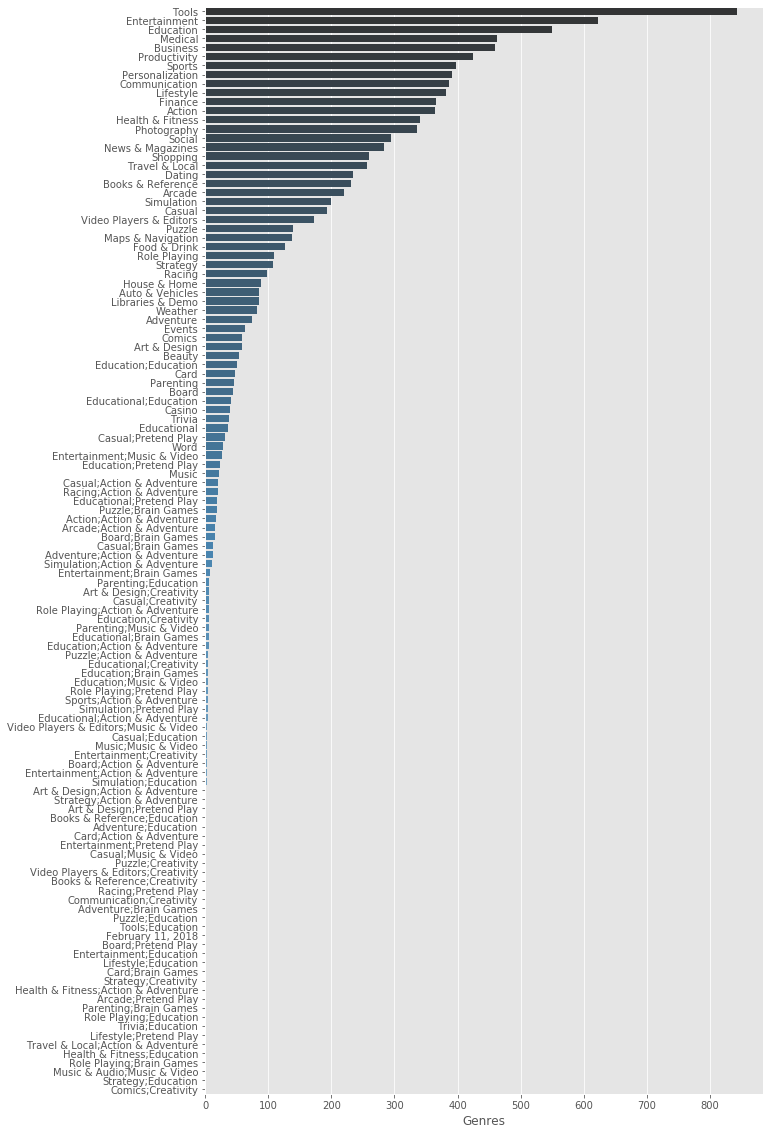

In [6]:
# Count by Genres
plt.figure(figsize=(10, 20))
sns.barplot(x=table['Genres'].value_counts(), y=table['Genres'].value_counts().index, palette='Blues_d')
plt.show()

> ### 'Genres' is more specific about what kinds of the applications, but there are too many genres and many genres that have very little data points. Therefore, it might be difficult to get insights about its attribute.
> ### On the other hand, 'Category' is less detail in segmenting applications but it is a better feature than 'Genres' because it is less complex. Moreover, there are enough data points in every category. ('Category' has an abnormal data point, '1.9', and this will resolve along the analysis)
> ### Dropping 'Genres' is a better choice in this analysis.

In [7]:
table = table.drop('Genres', axis=1)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 10 columns):
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Last Updated      10841 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(9)
memory usage: 847.0+ KB


> ### In 'Rating', there are many NaN values (9367 out of 10841, 86%).

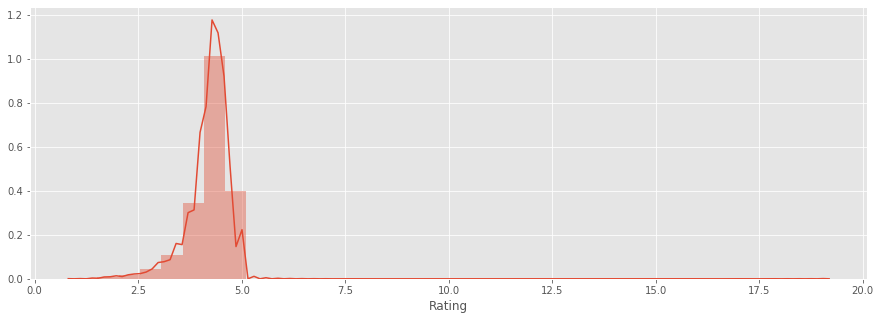

In [8]:
plt.figure(figsize=(15, 5))
sns.distplot(table['Rating'].dropna(), bins=35)
plt.show()

> ### It seems there is an abnormal data point. The maximum rating that an application can have is 5 but there is a higher value based on the plot above.

In [9]:
table['Rating'].sort_values(ascending=False).head(10)

10472    19.0
7435      5.0
8058      5.0
8234      5.0
8230      5.0
5450      5.0
9455      5.0
8159      5.0
8146      5.0
5482      5.0
Name: Rating, dtype: float64

In [10]:
table[table['Rating'] == table['Rating'].max()]

Category  Rating Reviews    Size Installs Type     Price Content Rating  \
10472      1.9    19.0    3.0M  1,000+     Free    0  Everyone            NaN   

      Last Updated Android Ver  
10472       1.0.19         NaN

> ### It looks like it's a mistake in data entry. Everything is pushed left from 'Category to 'Android Ver'.

#### Getting information about the application from Google Play Store website:  
<img src='img/Screen Shot 2019-12-02 at 3.40.36 AM.png' width="500">

In [11]:
# Fixing the data
table.iloc[10472] = table.iloc[10472].replace(['1.9', 19, '3.0M', 'Free', '0', 'Everyone', 'February 11, 2018', '1.0.19'], \
                                              ['LIFESTYLE', 2.5, 32, '5,000+', 'Free', 0, 'Lifestyle', 'February 11, 2018'])
table.iloc[10472] =table.iloc[10472].replace({'Content Rating': None}, 'Everyone')
table.iloc[10472] =table.iloc[10472].replace({'Android Ver': None}, '1.0.19')

table.iloc[10472]

Category                  LIFESTYLE
Rating                          2.5
Reviews                          32
Size                         1,000+
Installs                     5,000+
Type                           Free
Price                             0
Content Rating             Everyone
Last Updated      February 11, 2018
Android Ver                  1.0.19
Name: 10472, dtype: object

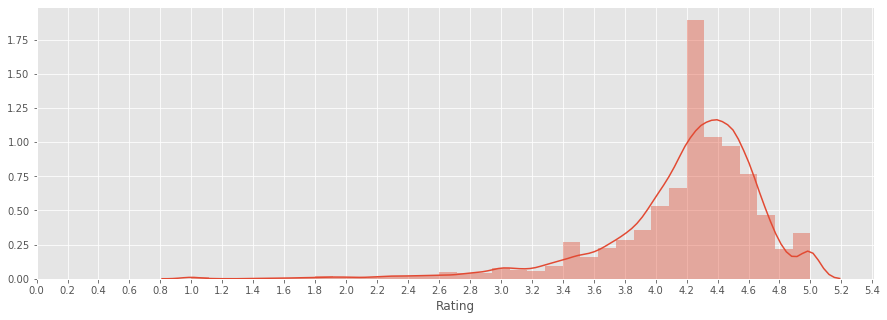

In [12]:
# Check the distribution
plt.figure(figsize=(15, 5))
sns.distplot(table['Rating'].dropna(), bins=35)
plt.xticks(np.arange(0, 5.5, step=0.2))
plt.show()

> ### If there is no difference between missing data and the rest, we could simply drop the missing data and continue to analyze the data because dropping the missing data will no affect the result of analysis.

> ### Change data types to proper data types for futher analysis.

In [13]:
# Remove unnecessary characters or words
table['Installs'] = table['Installs'].str.replace(',', '')
table['Installs'] = table['Installs'].str.replace('+', '')
table['Price'] = table['Price'].str.replace('$', '')
table['Android Ver'] = table['Android Ver'].str.replace('and up', '')

# Change to datetime data type
table['Last Updated'] = pd.to_datetime(table['Last Updated'],format='%B %d, %Y')

# Change to proper data types
table = table.astype({'Category':'category', 'Reviews': 'int', 'Installs': 'int','Type': 'category','Price': 'float'})
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 10 columns):
Category          10841 non-null category
Rating            9367 non-null float64
Reviews           10841 non-null int64
Size              10841 non-null object
Installs          10841 non-null int64
Type              10840 non-null category
Price             10840 non-null float64
Content Rating    10841 non-null object
Last Updated      10841 non-null datetime64[ns]
Android Ver       10839 non-null object
dtypes: category(2), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 700.4+ KB


In [14]:
# Select missing rating data
missing_rating = table[table['Rating'].isnull()]
# Select the rest of the data excluding missing rating data
nmissing_rating = table.iloc[np.delete(table.index, missing_rating.index)]

In [15]:
# Let's see missing values in each category
nmissing = nmissing_rating['Category'].value_counts()
missing = missing_rating['Category'].value_counts().reindex(nmissing_rating['Category'].value_counts().index)


diff = missing /nmissing

total = table['Category'].value_counts().reset_index()
total = total.rename(columns={'Category': 'Total', 'index': 'Category'})

result = pd.concat([nmissing, missing, diff], axis=1)
result.columns = ['Not Missing', 'Missing', 'Difference in %']
result = result.reset_index()
result = result.rename(columns={'index': 'Category'})
result = result.join(total.set_index('Category'), on='Category')
result = result.set_index('Category')

In [16]:
result.head()

Not Missing  Missing  Difference in %  Total
Category                                                  
FAMILY               1747      225         0.128792   1972
GAME                 1097       47         0.042844   1144
TOOLS                 734      109         0.148501    843
PRODUCTIVITY          351       73         0.207977    424
MEDICAL               350      113         0.322857    463

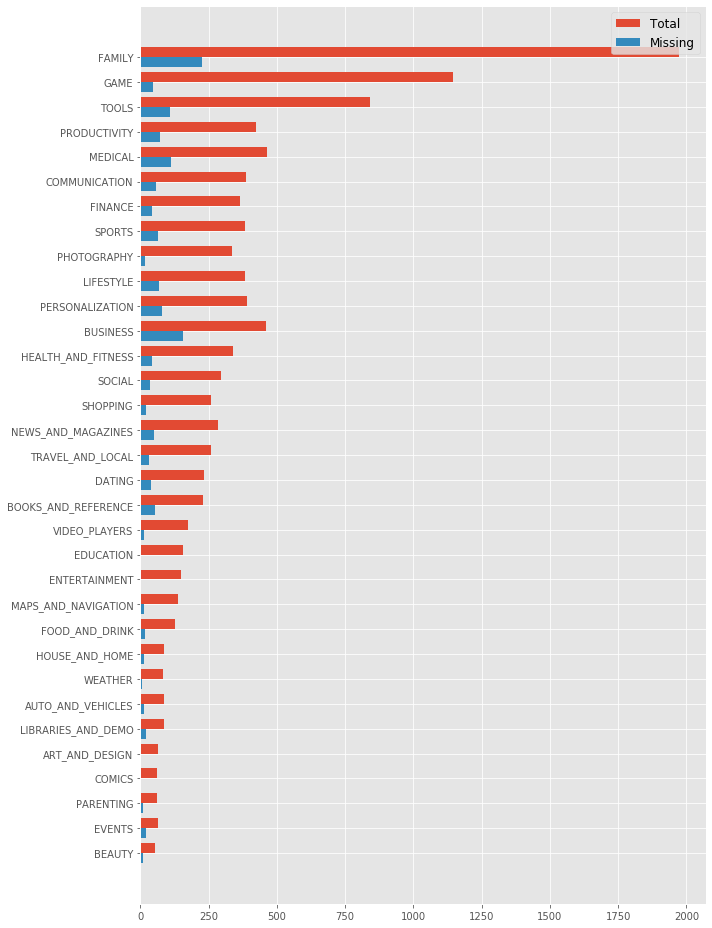

In [17]:
total = result['Total'].to_list()
missing = result['Missing'].to_list()
labels = result.index.to_list()

x = np.arange(len(labels))
width = 0.4

f, ax = plt.subplots(figsize=(10, 13))
bar1 = ax.barh(x + width/2, total[::-1],  width, label='Total')
bar2 = ax.barh(x - width/2, missing[::-1], width, label='Missing')

ax.set_yticks(x)
ax.set_yticklabels(labels[::-1])
f.tight_layout()
plt.legend(loc='upper right', fontsize='large')
plt.show()

In [18]:
# Getting number of review counts in descending order
print('Not missing:','\n', nmissing_rating['Reviews'].sort_values(ascending=False).head(10), '\n',
      '\n', 'Missing:','\n',missing_rating['Reviews'].sort_values(ascending=False).head(10))

Not missing: 
 2544    78158306
3943    78128208
336     69119316
381     69119316
3904    69109672
2604    66577446
2611    66577313
2545    66577313
3909    66509917
382     56646578
Name: Reviews, dtype: int64 
 
 Missing: 
 3589    3248
9567    2536
1559    2221
321     1330
9612    1317
3621     970
704      776
126      654
5840     649
1520     487
Name: Reviews, dtype: int64


In [19]:
# Getting general statistics for 'Reviews'
print('Not missing:','\n', nmissing_rating['Reviews'].describe().apply(lambda x: format(round(x,2), 'f')), '\n',
      '\n', 'Missing:','\n',missing_rating['Reviews'].describe().apply(lambda x: format(round(x,2), 'f')))

Not missing: 
 count        9367.000000
mean       513994.960000
std       3143878.770000
min             1.000000
25%           186.000000
50%          5928.000000
75%         81522.500000
max      78158306.000000
Name: Reviews, dtype: object 
 
 Missing: 
 count    1474.000000
mean       18.060000
std       139.910000
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max      3248.000000
Name: Reviews, dtype: object


> ### We can see there is huge differences between data with missing values in 'Rating' and the data without missing values.  
> ### Let's see where missing values' distributions belong to data that contain 0 missing value.

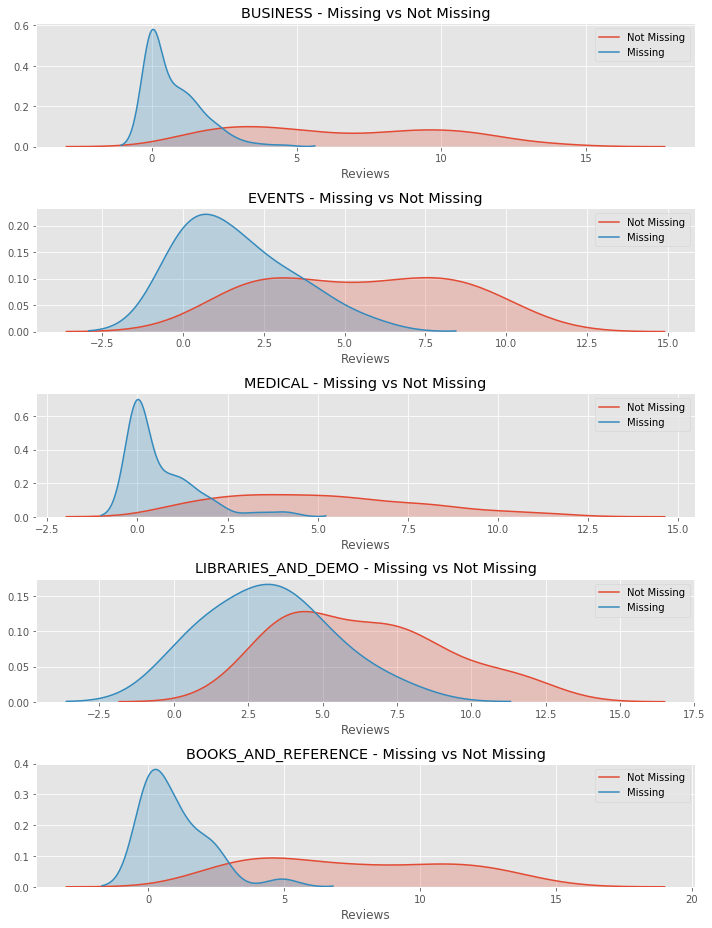

In [20]:
# Comparision in Reviews
f, ax = plt.subplots(5,1, figsize=(10, 13))
axes = [0, 1, 2, 3, 4, 5]

for i in range(0,5):
    sns.distplot(np.log(nmissing_rating[nmissing_rating['Category'] == result.sort_values('Difference in %', ascending=False).index[i]]['Reviews']+1),\
                 hist=False, kde_kws={'shade': True}, ax=ax[axes[i]], label='Not Missing')
    sns.distplot(np.log(missing_rating[missing_rating['Category'] == result.sort_values('Difference in %', ascending=False).index[i]]['Reviews']+1),\
                 hist=False, kde_kws={'shade': True},ax=ax[axes[i]], label='Missing').set_title(result.sort_values('Difference in %', ascending=False).index[i] + ' - Missing vs Not Missing')
    
plt.tight_layout()
plt.legend()
plt.show()

In [21]:
# Getting number of installs in descending order
print('Not missing:','\n', nmissing_rating['Installs'].sort_values(ascending=False).head(10), '\n',
      '\n', 'Missing:','\n',missing_rating['Installs'].sort_values(ascending=False).head(10))

Not missing: 
 3736    1000000000
1700    1000000000
4098    1000000000
3943    1000000000
2554    1000000000
3232    1000000000
3565    1000000000
3234    1000000000
2853    1000000000
2545    1000000000
Name: Installs, dtype: int64 
 
 Missing: 
 3258    1000000
3252    1000000
1559     500000
23       100000
704      100000
9567     100000
9557     100000
5734     100000
3621     100000
3599     100000
Name: Installs, dtype: int64


In [22]:
# Getting general statistics for 'Installs'
print('Not missing:','\n', nmissing_rating['Installs'].describe().apply(lambda x: format(round(x,2), 'f')), '\n',
      '\n', 'Missing:','\n',missing_rating['Installs'].describe().apply(lambda x: format(round(x,2), 'f')))

Not missing: 
 count          9367.000000
mean       17895533.570000
std        91233533.840000
min               1.000000
25%           10000.000000
50%          500000.000000
75%         5000000.000000
max      1000000000.000000
Name: Installs, dtype: object 
 
 Missing: 
 count       1474.000000
mean        4053.970000
std        40795.980000
min            0.000000
25%           10.000000
50%          100.000000
75%          500.000000
max      1000000.000000
Name: Installs, dtype: object


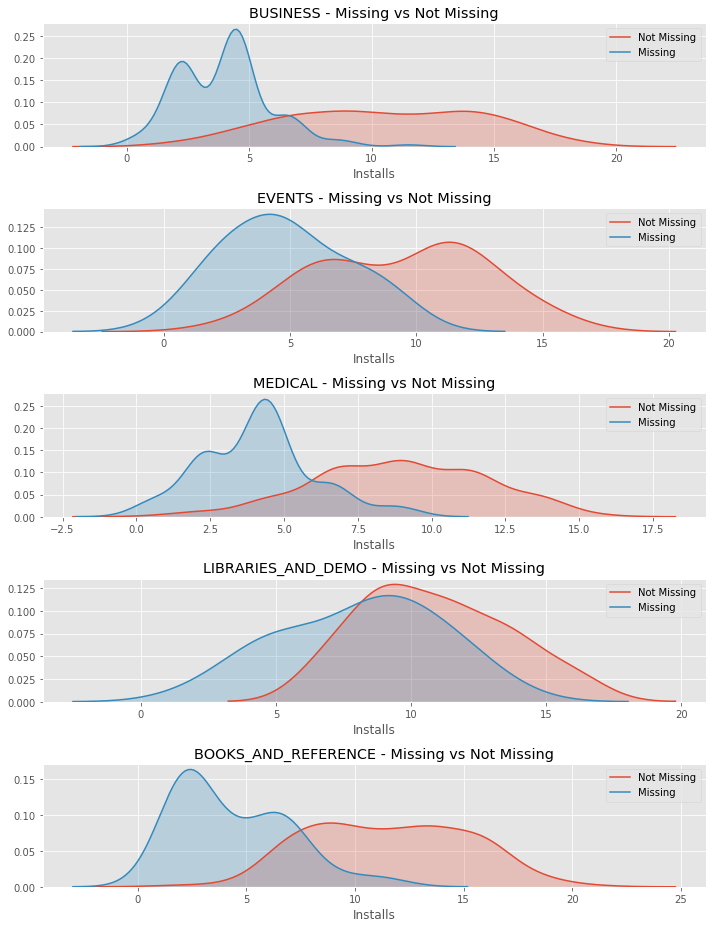

In [23]:
# Comparision in Installs
f, ax = plt.subplots(5,1, figsize=(10, 13))
axes = [0, 1, 2, 3, 4, 5]

for i in range(0,5):
    sns.distplot(np.log(nmissing_rating[nmissing_rating['Category'] == result.sort_values('Difference in %', ascending=False).index[i]]['Installs']+1),\
                 hist=False, kde_kws={'shade': True}, ax=ax[axes[i]], label='Not Missing')
    sns.distplot(np.log(missing_rating[missing_rating['Category'] == result.sort_values('Difference in %', ascending=False).index[i]]['Installs']+1),\
                 hist=False, kde_kws={'shade': True},ax=ax[axes[i]], label='Missing').set_title(result.sort_values('Difference in %', ascending=False).index[i] + ' - Missing vs Not Missing')
    
plt.tight_layout()
plt.legend()
plt.show()

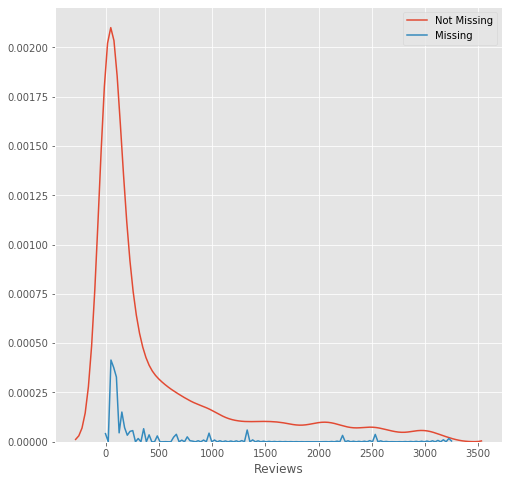

In [24]:
plt.figure(figsize=(8,8))

sns.distplot(nmissing_rating[nmissing_rating['Reviews'] <= 3248]['Reviews'], kde=True, hist=False,label='Not Missing')
sns.distplot(missing_rating['Reviews'], kde=True, hist=False, label='Missing')

plt.legend()
plt.show()

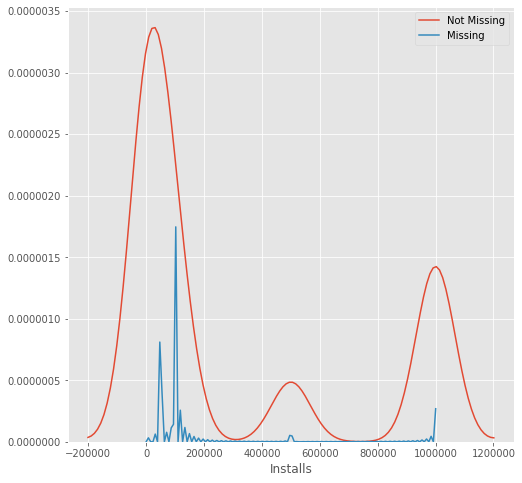

In [25]:
plt.figure(figsize=(8,8))

sns.distplot(nmissing_rating[nmissing_rating['Installs'] <= 1000000]['Installs'], kde=True, hist=False,label= 'Not Missing')
sns.distplot(missing_rating['Installs'], kde=True, hist=False,label='Missing')

plt.legend()
plt.show()

In [26]:
# Getting 'Price' in descending order
print('Not missing:','\n', nmissing_rating['Price'].sort_values(ascending=False).head(10), '\n',
      '\n', 'Missing:','\n',missing_rating['Price'].sort_values(ascending=False).head(10))

Not missing: 
 4367    400.00
5354    399.99
4197    399.99
4362    399.99
5356    399.99
5351    399.99
5358    399.99
5359    399.99
5362    399.99
5364    399.99
Name: Price, dtype: float64 
 
 Missing: 
 9934    399.99
9917    394.99
9719    200.00
6692    154.99
6624    109.99
9730     89.99
2390     74.99
6559     46.99
4134     39.99
9905     30.99
Name: Price, dtype: float64


In [27]:
# Getting general statistics for 'Price'
print('Not missing:','\n', nmissing_rating['Price'].describe().apply(lambda x: format(round(x,2), 'f')), '\n',
      '\n', 'Missing:','\n',missing_rating['Price'].describe().apply(lambda x: format(round(x,2), 'f')))

Not missing: 
 count    9366.000000
mean        0.960000
std        15.820000
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       400.000000
Name: Price, dtype: object 
 
 Missing: 
 count    1474.000000
mean        1.450000
std        16.770000
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       399.990000
Name: Price, dtype: object


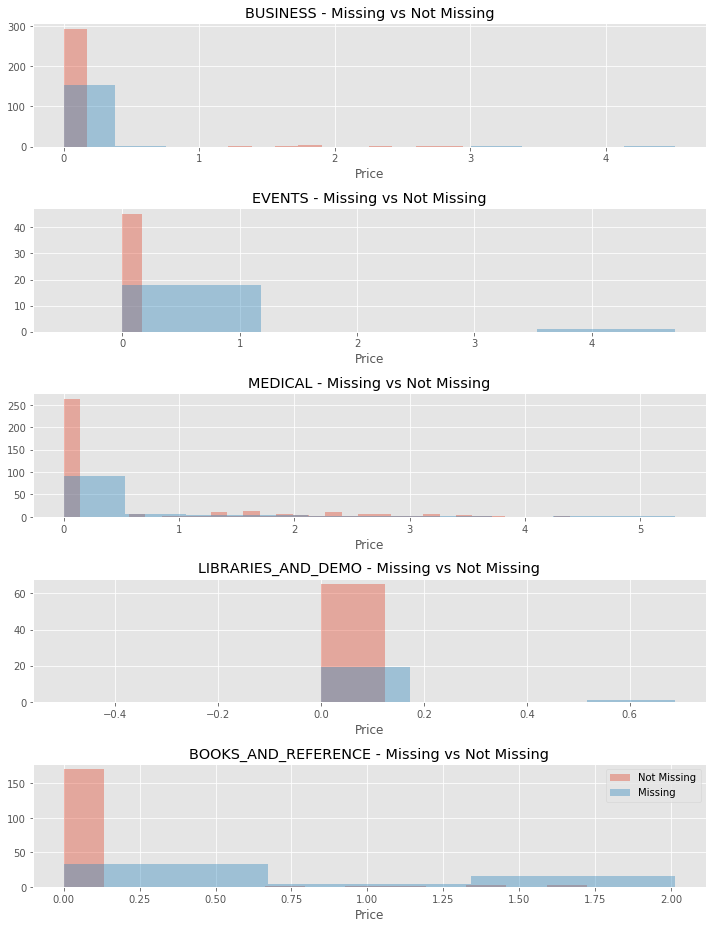

In [28]:
# Comparision in Installs
f, ax = plt.subplots(5,1, figsize=(10, 13))
axes = [0, 1, 2, 3, 4, 5]

for i in range(0,5):
    sns.distplot(np.log(nmissing_rating[nmissing_rating['Category'] == result.sort_values('Difference in %', ascending=False).index[i]]['Price']+1),\
                 hist=True, kde=False, ax=ax[axes[i]], label='Not Missing')
    sns.distplot(np.log(missing_rating[missing_rating['Category'] == result.sort_values('Difference in %', ascending=False).index[i]]['Price']+1),\
                 hist=True, kde=False, ax=ax[axes[i]], label='Missing').set_title(result.sort_values('Difference in %', ascending=False).index[i] + ' - Missing vs Not Missing')

plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

> ### 'Installs' and 'Price' give a similar result as 'Reviews'; therefore, dropping missing values is reasonable choice in this case.  
#### Note: It looks like most missing values in 'Rating' were caused due to the lack of engagement in reviewing and downloading applications.

In [29]:
# Dropping missing values
table = table.dropna()

table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9364 entries, 0 to 10840
Data columns (total 10 columns):
Category          9364 non-null category
Rating            9364 non-null float64
Reviews           9364 non-null int64
Size              9364 non-null object
Installs          9364 non-null int64
Type              9364 non-null category
Price             9364 non-null float64
Content Rating    9364 non-null object
Last Updated      9364 non-null datetime64[ns]
Android Ver       9364 non-null object
dtypes: category(2), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 678.3+ KB


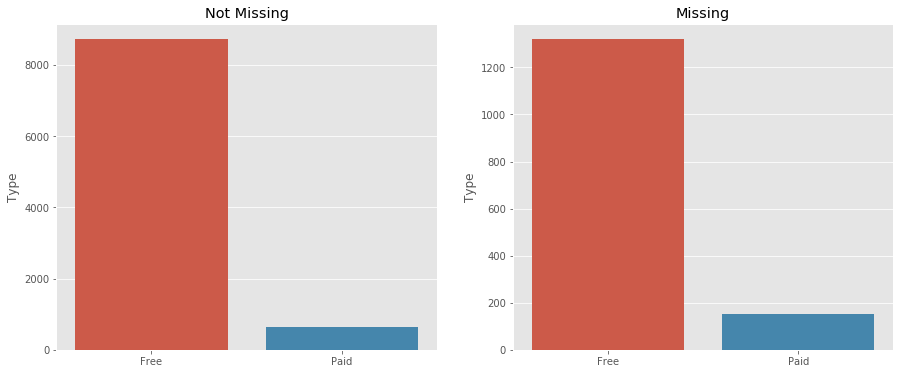

In [30]:
f,ax = plt.subplots(1,2, figsize=(15, 6))

ax1 = sns.barplot(x=nmissing_rating['Type'].value_counts().index, y=nmissing_rating['Type'].value_counts(), ax=ax[0]).set_title('Not Missing')
ax2 = sns.barplot(x=missing_rating['Type'].value_counts().index, y=missing_rating['Type'].value_counts(), ax=ax[1]).set_title('Missing')

plt.show()

In [31]:
missing_rating['Type'].value_counts()[1] / missing_rating['Type'].value_counts()[0]

0.1159090909090909

In [32]:
nmissing_rating['Type'].value_counts()[1] / nmissing_rating['Type'].value_counts()[0]

0.07419724770642201

In [33]:
table.head()

Category  Rating  Reviews  Size  Installs  Type  Price  \
0  ART_AND_DESIGN     4.1      159   19M     10000  Free    0.0   
1  ART_AND_DESIGN     3.9      967   14M    500000  Free    0.0   
2  ART_AND_DESIGN     4.7    87510  8.7M   5000000  Free    0.0   
3  ART_AND_DESIGN     4.5   215644   25M  50000000  Free    0.0   
4  ART_AND_DESIGN     4.3      967  2.8M    100000  Free    0.0   

  Content Rating Last Updated Android Ver  
0       Everyone   2018-01-07      4.0.3   
1       Everyone   2018-01-15      4.0.3   
2       Everyone   2018-08-01      4.0.3   
3           Teen   2018-06-08        4.2   
4       Everyone   2018-06-20        4.4

In [34]:
# For better comparision, normalize continuous features.
trans_table = table.copy()

trans_table['Reviews'] = trans_table['Reviews'].apply(np.log)
trans_table['Installs'] = trans_table['Installs'].apply(np.log)

In [35]:
trans_table = trans_table.drop(['Type', 'Price'], axis=1)

In [36]:
trans_table['Size'] = trans_table['Size'].str.replace('M', '')

In [37]:
trans_table['Size']

0                        19
1                        14
2                       8.7
3                        25
4                       2.8
5                       5.6
6                        19
7                        29
8                        33
9                       3.1
10                       28
11                       12
12                       20
13                       21
14                       37
15                      2.7
16                      5.5
17                       17
18                       39
19                       31
20                       14
21                       12
22                      4.2
24                       23
25                      6.0
26                       25
27                      6.1
28                      4.6
29                      4.2
30                      9.2
                ...        
10795                   4.0
10796                   7.8
10797                    46
10799                   6.8
10800               

In [38]:
trans_table['Size'] = trans_table['Size'].str.replace('k', '')

In [39]:
# Thinking about how to deal with 'Varies with device'
sizeinfo = trans_table[trans_table['Size'] != 'Varies with device'].loc[:,'Size'].astype('float')

In [40]:
print(' Mean: ', sizeinfo.mean(), '\n', 'Median: ', sizeinfo.median(), '\n', 'Mode: ', sizeinfo.mode()[0])

 Mean:  37.29246796945767 
 Median:  16.0 
 Mode:  14.0


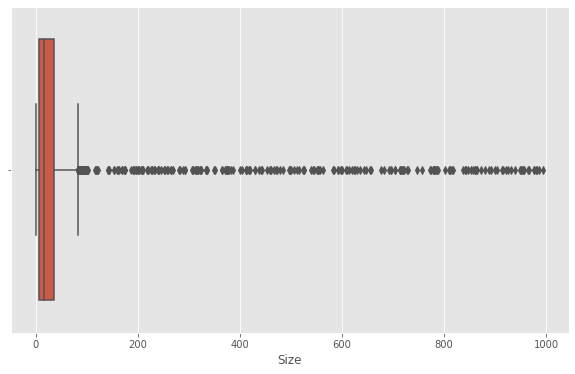

In [41]:
plt.figure(figsize=(10,6))

sns.boxplot(sizeinfo)

plt.show()

In [42]:
trans_table['Size'] = trans_table['Size'].str.replace('Varies with device', str(sizeinfo.median()))
trans_table['Size'] = trans_table['Size'].astype('float')
# Big gap
trans_table['Size'] = np.log(trans_table['Size'])

## EDA

> ### Let's see overall relationship among continuous features.

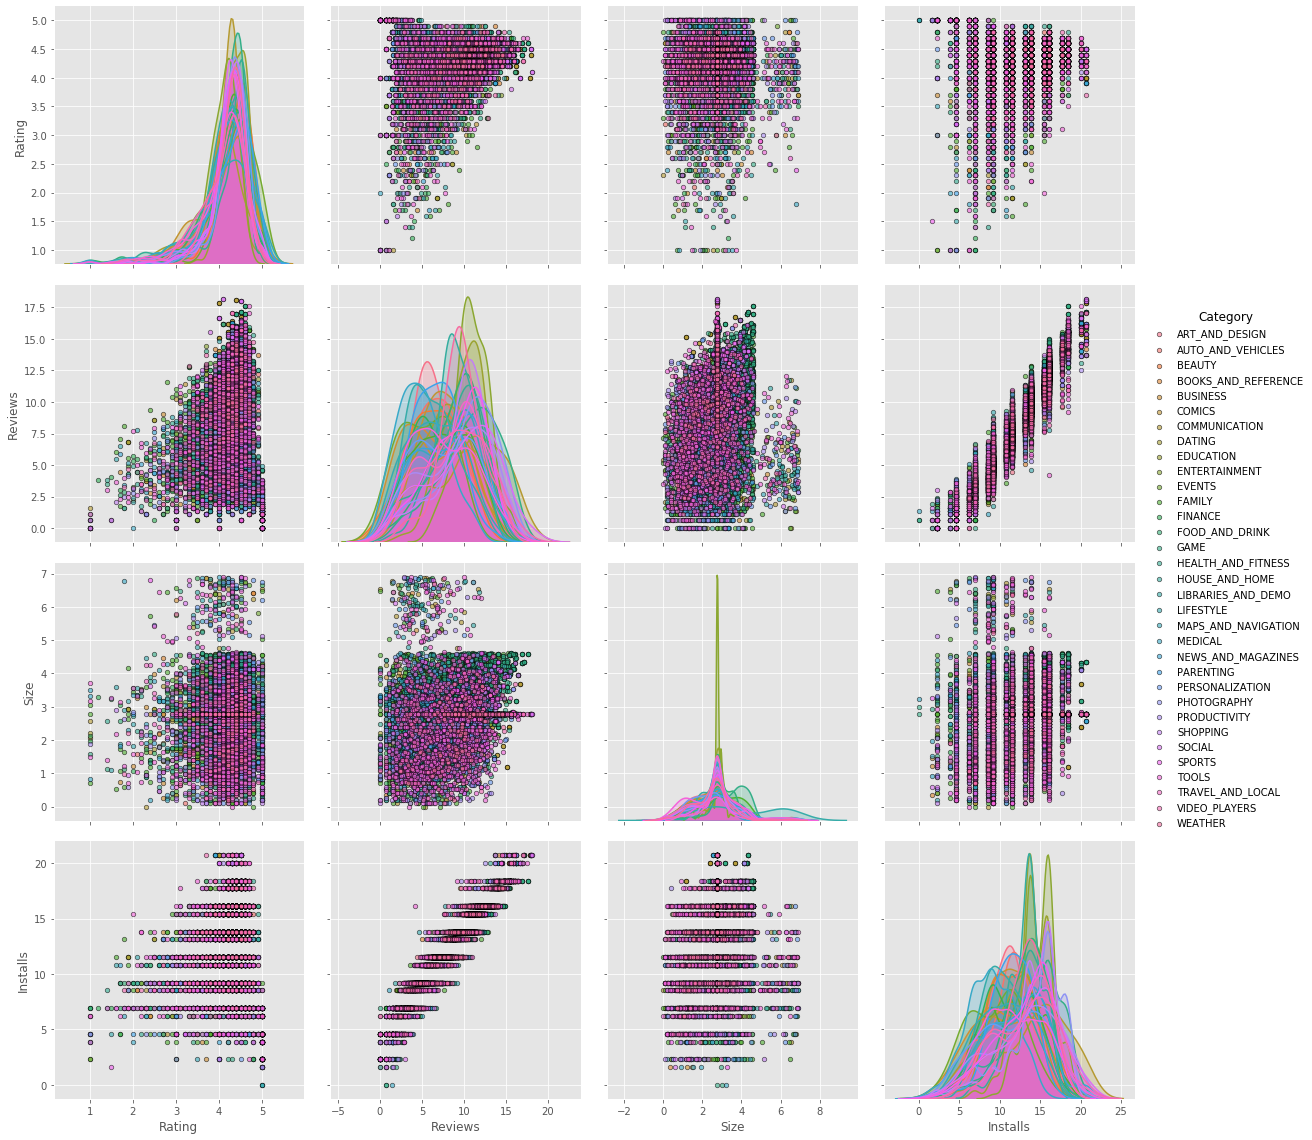

In [43]:
sns.pairplot(trans_table, hue='Category', diag_kind='kde', markers=".", plot_kws={'alpha': 0.6, 's':80, 'edgecolor': 'k'}, height=4)
plt.show()

> ### We can see 'Reviews' and 'Installs' have a linear relationship. Since 'Installs' is less detail data (original value was like '+100000', and I dropped '+' and transformed to integer data type), it is more efficient to drop 'Installs' and use 'Reviews' due to redundancy in the analysis.

In [44]:
# Drop 'Installs'
trans_table = trans_table.drop('Installs', axis=1)

## Reviews

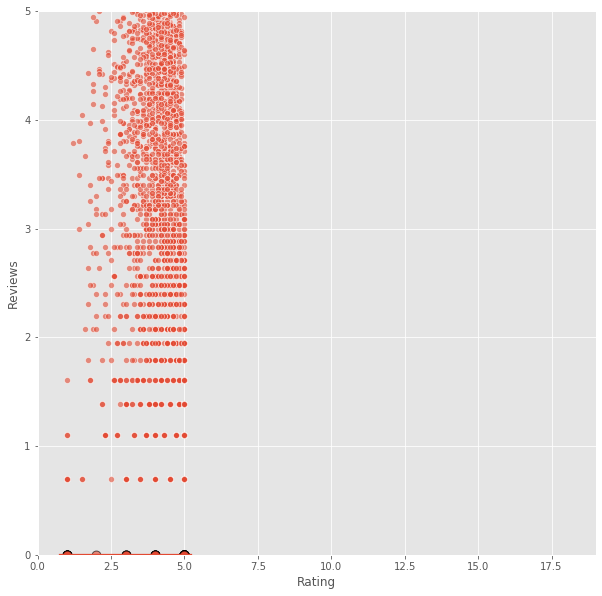

In [45]:
# Create an animation that shows the difference relationships between 'Reviews' and 'Rating' based on 'Reviews' values
review_range = list(np.arange(0, 19, 0.1))

writer_init = animation.writers['ffmpeg']
writer = writer_init(fps=30, metadata=dict(artist='Hyunil Yoo'), bitrate=1800)

f = plt.figure(figsize=(10, 10))
 
def animate(i):
    plt.cla()
    above = trans_table[trans_table['Reviews'] > review_range[i]]
    below = trans_table[trans_table['Reviews'] <= review_range[i]]
    sns.scatterplot(x=above['Rating'], y=above['Reviews'],alpha= 0.6)
    sns.regplot(x=below['Rating'], y=below['Reviews'], scatter_kws={'alpha': 0.6, 's':80, 'edgecolor': 'k'})
    plt.xlim(0, 19)
    plt.ylim(0, 5)
    
ani = animation.FuncAnimation(f, animate, frames=len(review_range), repeat=True)
ani.save('review_rating_3.mp4', writer=writer)

In [46]:
# For axes
zero = [0] * 11
one = [1] * 11
two = [2] * 11

flat_colax = zero + one + two

rowax = [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rowax = rowax *3

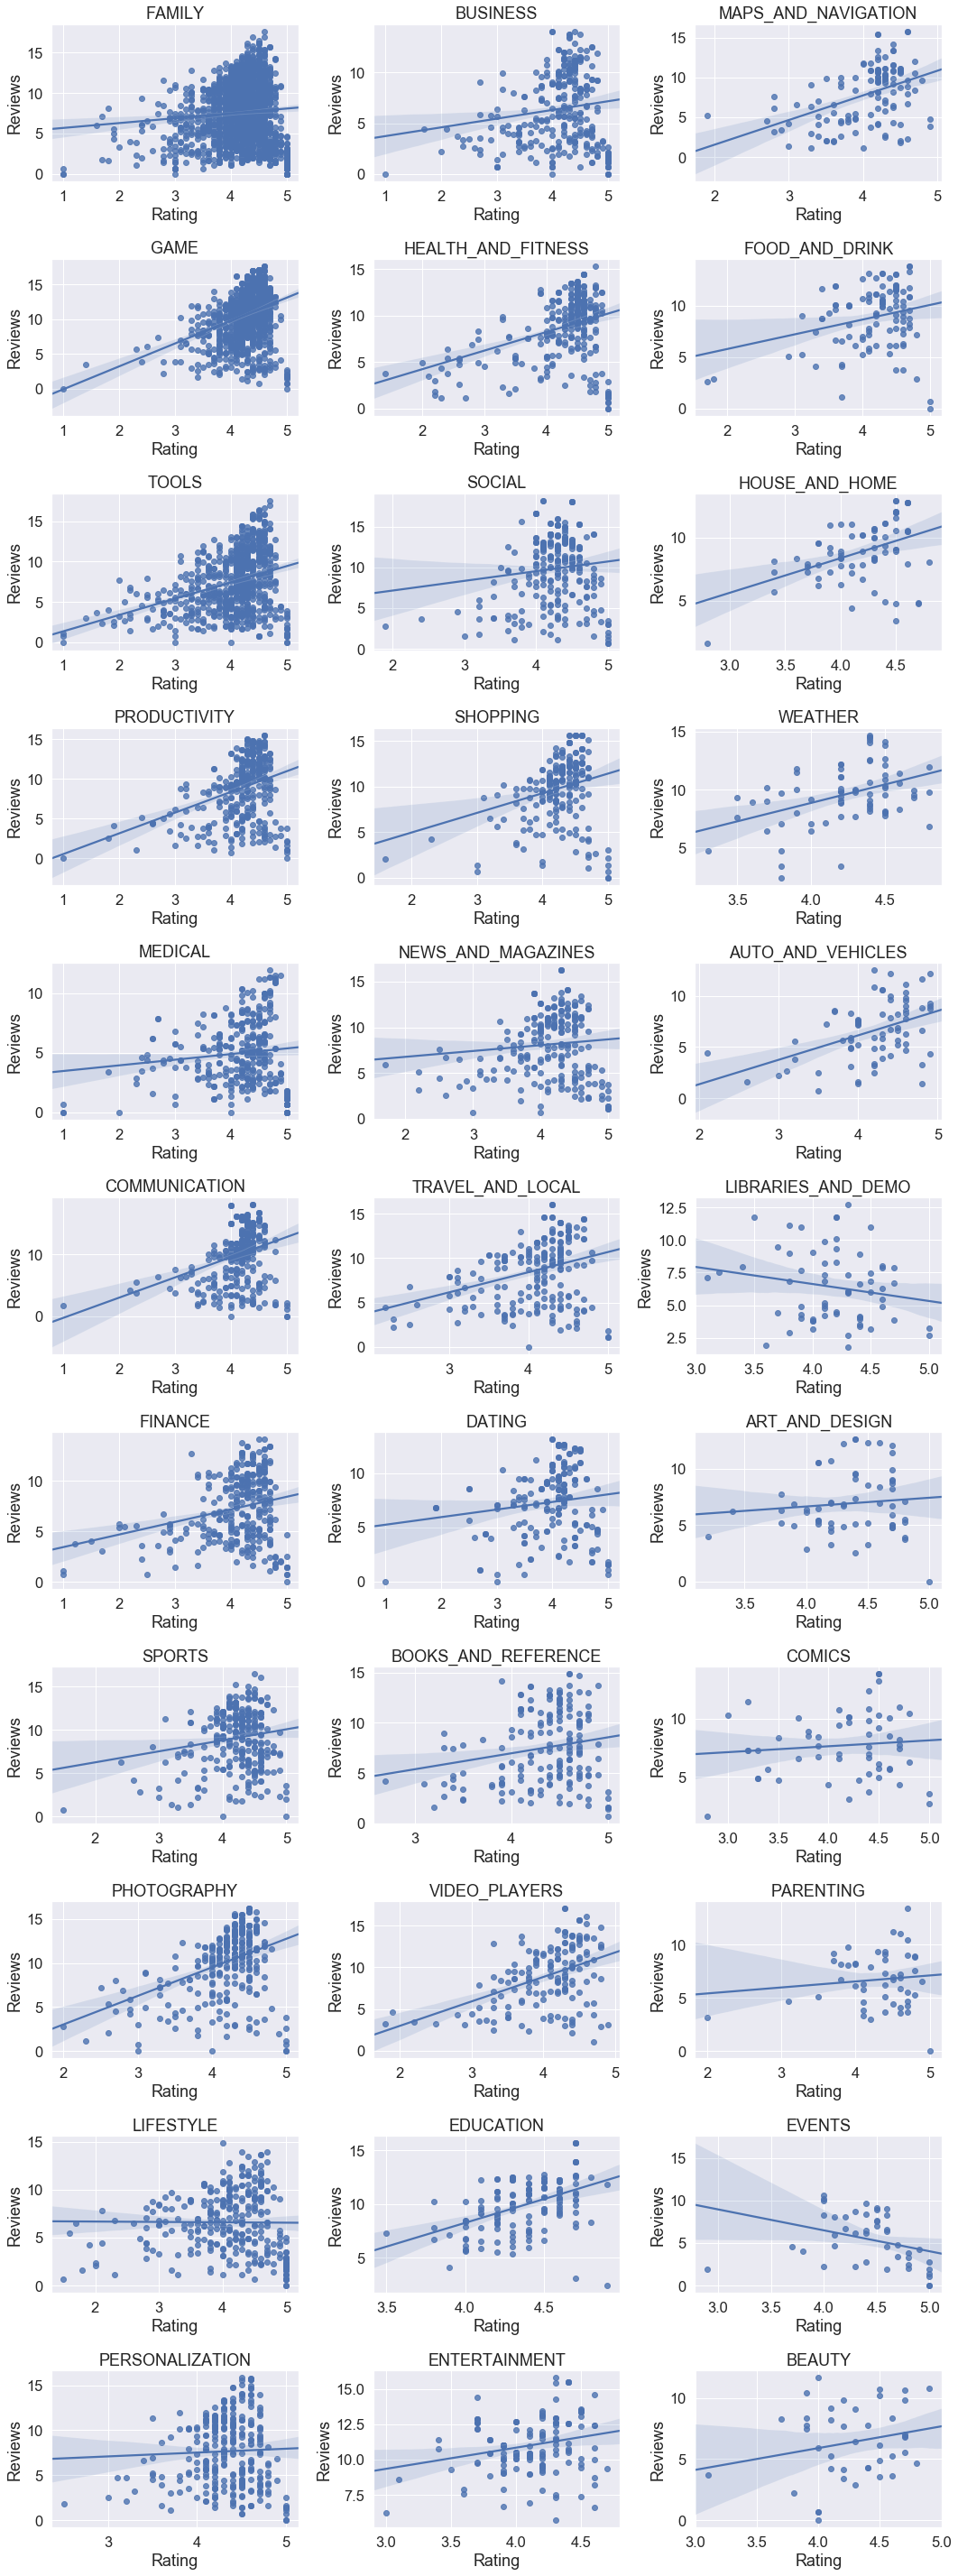

In [47]:
sns.set(font_scale=1.5)
f, ax = plt.subplots(11, 3, figsize=(15, 40))

category = trans_table['Category'].value_counts().index

for i in range(0,33):
    sns.regplot(trans_table[trans_table['Category'] == category[i]]['Rating'], \
                trans_table[trans_table['Category'] == category[i]]['Reviews'], \
                color='b',ax=ax[rowax[i], flat_colax[i]]).set_title(category[i])

plt.tight_layout()
plt.show()

sns.set(font_scale=1)
plt.style.use('ggplot')

## Size

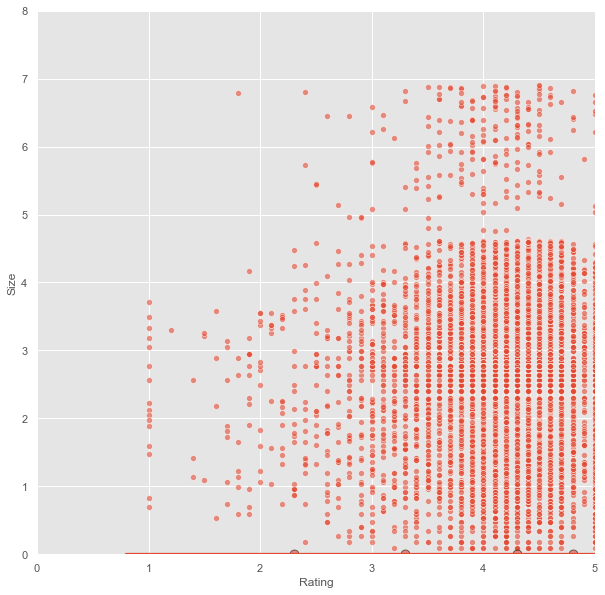

In [48]:
# Create an animation that shows the difference relationships between 'Size' and 'Rating' based on 'Size' values
size_range = list(np.arange(0, 8, 0.1))

writer_init = animation.writers['ffmpeg']
writer = writer_init(fps=30, metadata=dict(artist='Hyunil Yoo'), bitrate=1800)

f = plt.figure(figsize=(10, 10))
 
def animate(i):
    plt.cla()
    above = trans_table[trans_table['Size'] > size_range[i]]
    below = trans_table[trans_table['Size'] <= size_range[i]]
    sns.scatterplot(above['Rating'], above['Size'], alpha= 0.6)
    sns.regplot(below['Rating'], below['Size'], scatter_kws={'alpha': 0.6, 's':80, 'edgecolor': 'k'})
    plt.xlim(0, 5)
    plt.ylim(0, 8)
    
ani = animation.FuncAnimation(f, animate, frames=len(size_range), repeat=True)
ani.save('size_rating.mp4', writer=writer)

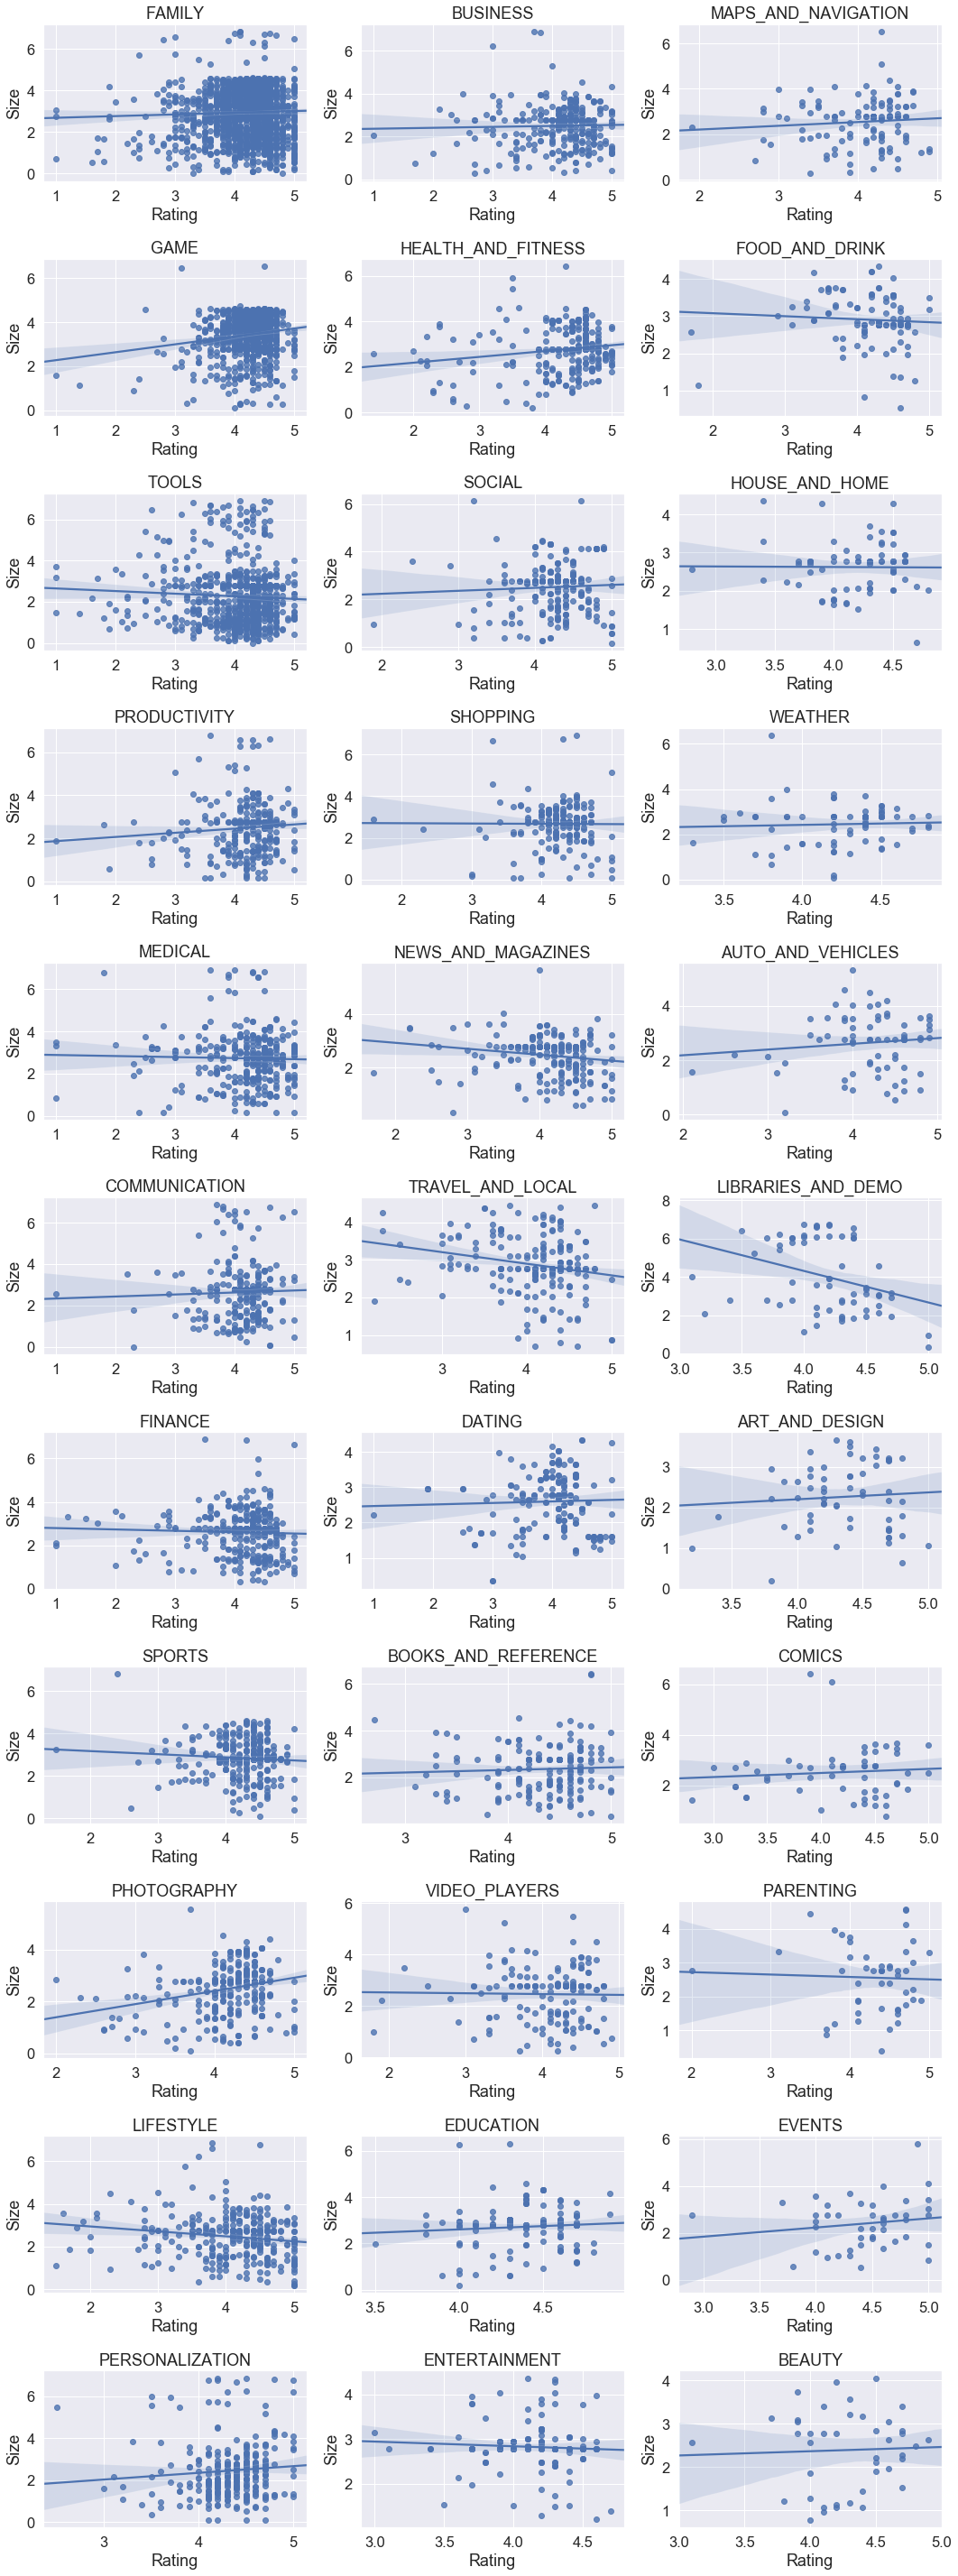

In [49]:
sns.set(font_scale=1.5)
f, ax = plt.subplots(11, 3, figsize=(15, 40))

category = trans_table['Category'].value_counts().index

for i in range(0,33):
    sns.regplot(trans_table[trans_table['Category'] == category[i]]['Rating'], y=trans_table[trans_table['Category'] == category[i]]['Size'], color='b',ax=ax[rowax[i], flat_colax[i]]).set_title(category[i])

plt.tight_layout()
plt.show()

sns.set(font_scale=1)
plt.style.use('ggplot')

In [50]:
# Drop 'Size'
trans_table = trans_table.drop('Size', axis=1)

## Last Updated

In [51]:
trans_table['Last Updated'].max()

Timestamp('2018-08-08 00:00:00')

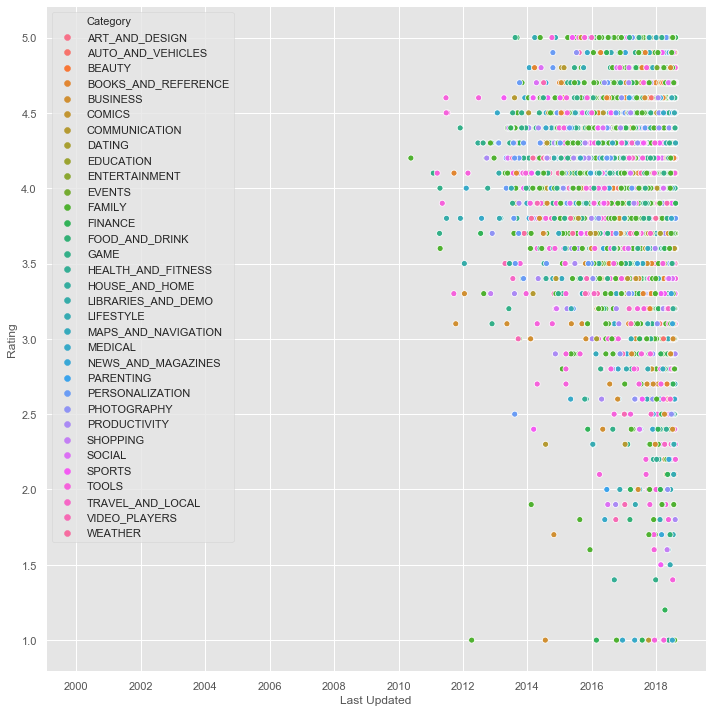

In [52]:
plt.figure(figsize=(10,10))

sns.scatterplot(x=trans_table['Last Updated'], y=trans_table['Rating'], hue=trans_table['Category'])
plt.tight_layout()
plt.show()

> ### We can get an idea about how users care about application version updates.

In [53]:
# Drop Last Update
trans_table = trans_table.drop('Last Updated', axis=1)

## Android Ver

In [54]:
version = trans_table['Android Ver'].to_list()

In [55]:
for i in range(len(version)):
    version[i] = re.sub('(.[^.]).', r'\1', version[i])

In [56]:
version = pd.Series(version)

In [57]:
version_stats = version.where(version != 'Vaie wthdeic').dropna()

In [58]:
version_stats[version_stats == '4.03  71.1']

338    4.03  71.1
340    4.03  71.1
dtype: object

In [59]:
version[338] = version[338][:4]
version[340] = version[340][:4]
version_stats[338] = version[338][:4]
version_stats[340] = version[340][:4]

In [60]:
version[version == '7.0- .11']

1490    7.0- .11
dtype: object

In [61]:
version[1490] = version[1490][:3]
version_stats[1490] = version_stats[1490][:3]

In [62]:
version[version == '5.0- .0']

2702    5.0- .0
3333    5.0- .0
6759    5.0- .0
dtype: object

In [63]:
version[2702] = version[2702][:3]
version[3333] = version[3333][:3]
version[6759] = version[6759][:3]
version_stats[2702] = version_stats[2702][:3]
version_stats[3333] = version_stats[3333][:3]
version_stats[6759] = version_stats[6759][:3]

In [64]:
version[version == '4.1- .11']

3993    4.1- .11
dtype: object

In [65]:
version[3993] = version[3993][:3]
version_stats[3993] = version_stats[3993][:3]

In [66]:
version_stats = version_stats.astype('float')

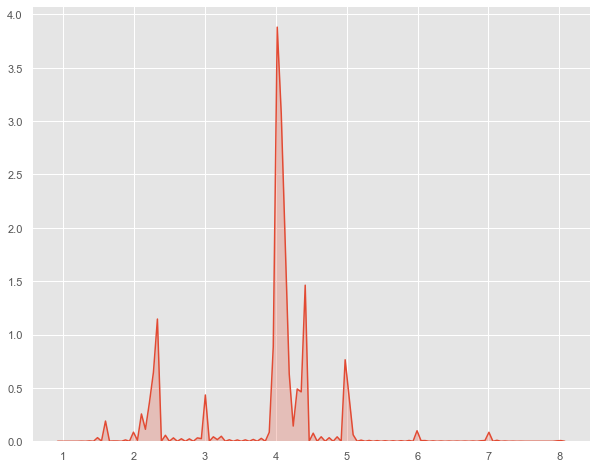

In [67]:
plt.figure(figsize=(10,8))
sns.distplot(version_stats, hist=False, kde_kws={'shade': True})
plt.show()

In [68]:
print(' Mean: ', version_stats.mean(), '\n', 'Median: ', version_stats.median(), '\n', 'Mode: ', version_stats.mode()[0])

 Mean:  3.8743853325044997 
 Median:  4.1 
 Mode:  4.1


In [69]:
version = version.str.replace('Vaie wthdeic', str(version_stats.median()))
version = version.astype('float')

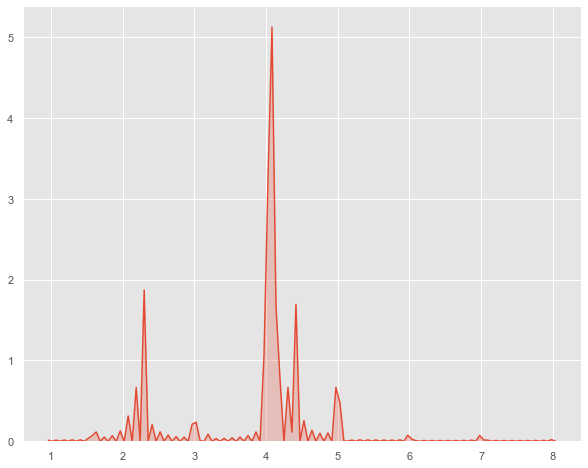

In [70]:
plt.figure(figsize=(10,8))
sns.distplot(version, hist=False, kde_kws={'shade': True})
plt.show()

In [71]:
trans_table['Android Ver'] = version.to_list()

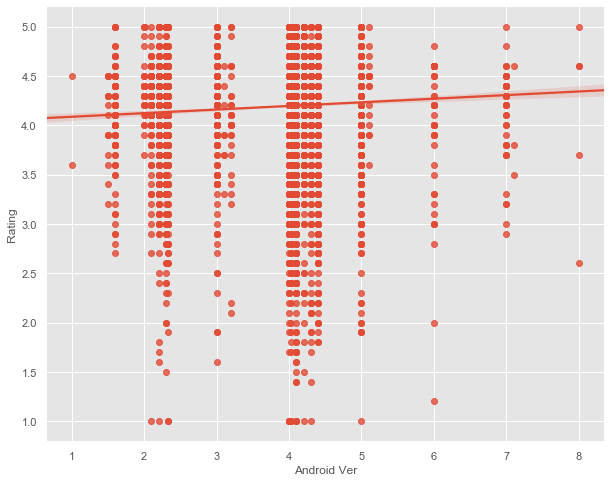

In [72]:
plt.figure(figsize=(10,8))
sns.regplot(x=trans_table['Android Ver'], y=trans_table['Rating'])
plt.show()

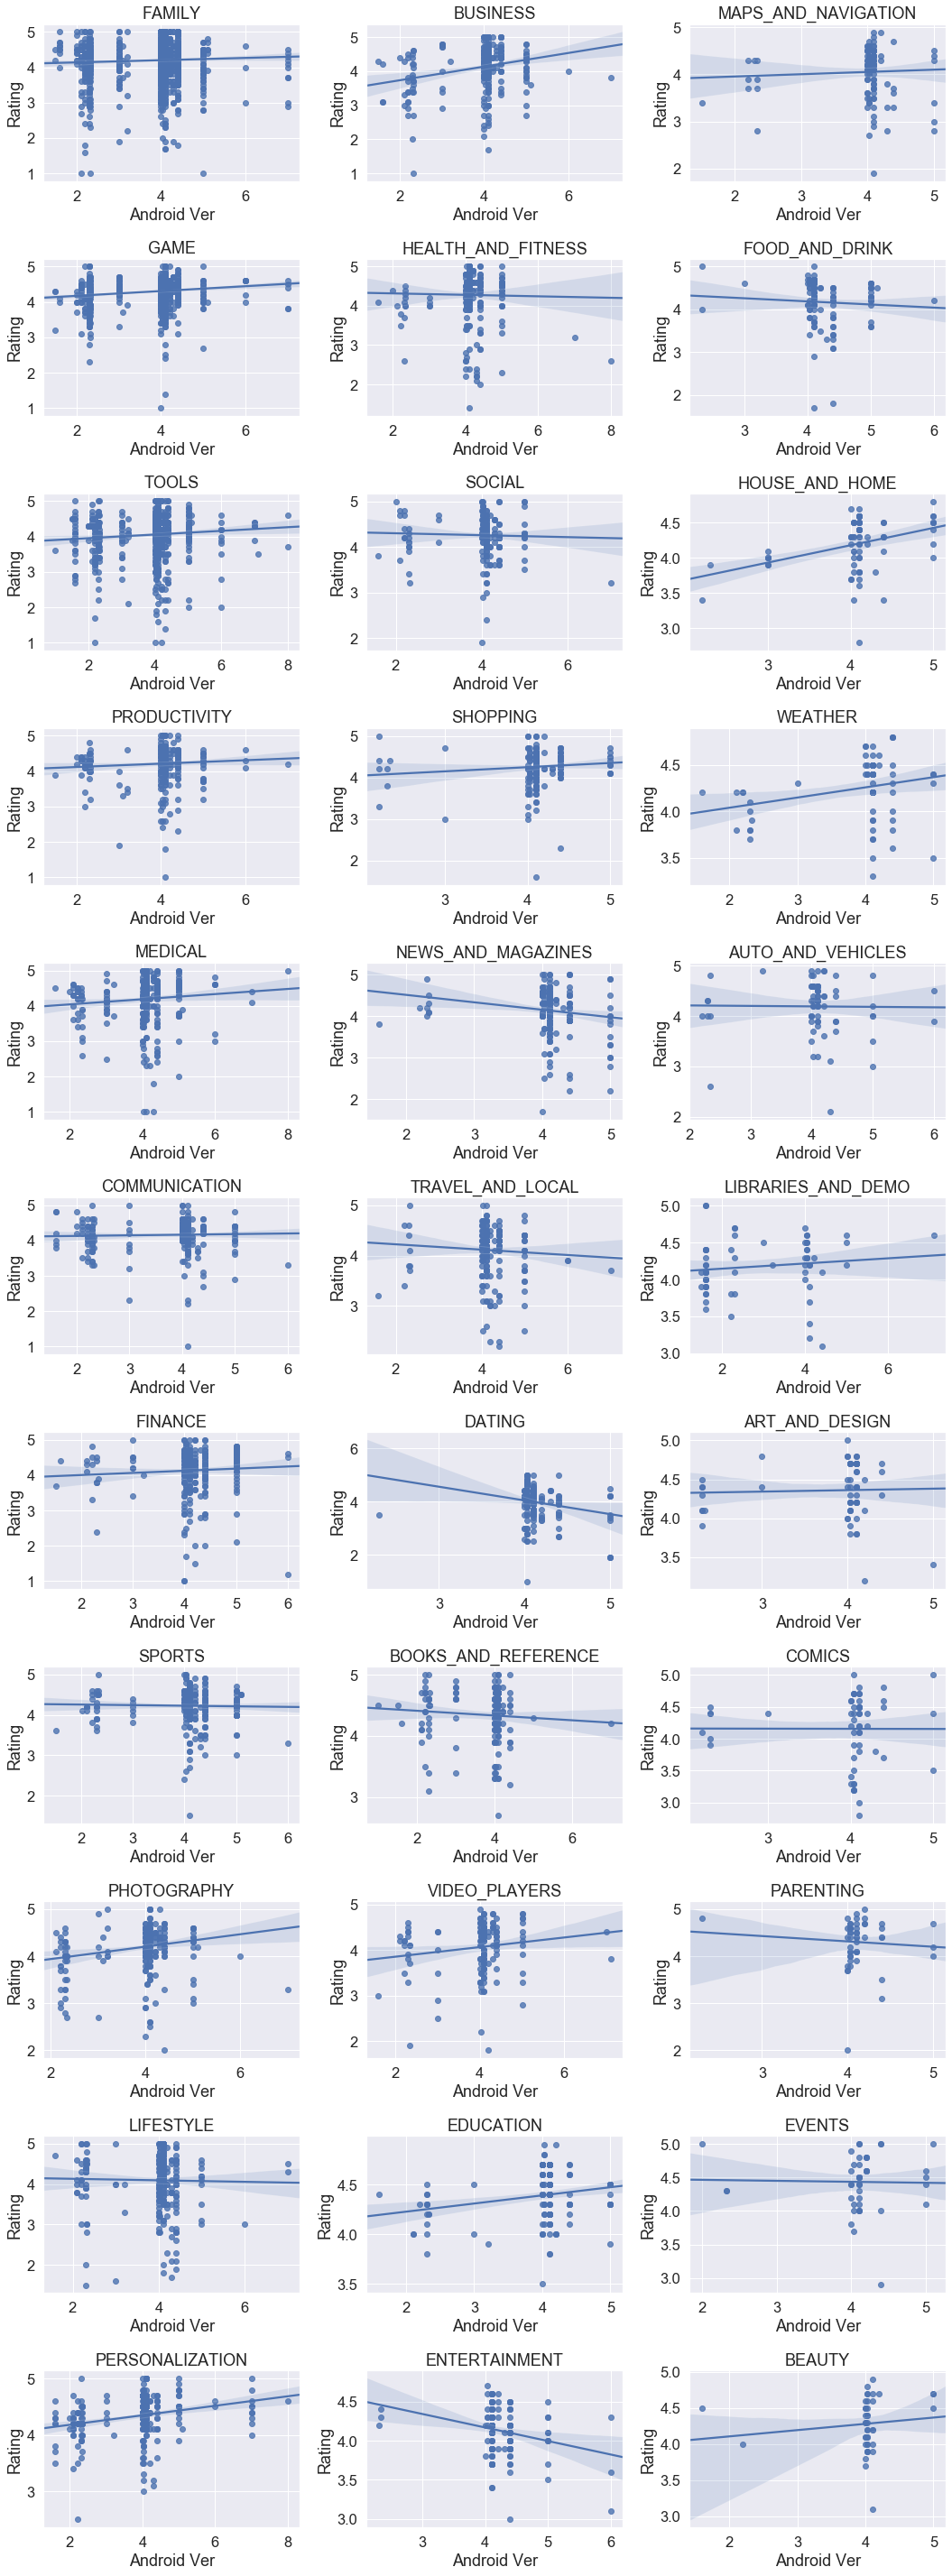

In [73]:
sns.set(font_scale=1.5)
f, ax = plt.subplots(11, 3, figsize=(15, 40))

category = trans_table['Category'].value_counts().index

for i in range(0,33):
    sns.regplot(x=trans_table[trans_table['Category'] == category[i]]['Android Ver'], y=trans_table[trans_table['Category'] == category[i]]['Rating'], color='b',ax=ax[rowax[i], flat_colax[i]]).set_title(category[i])

plt.tight_layout()
plt.show()

sns.set(font_scale=1)
plt.style.use('ggplot')

## Content Rating

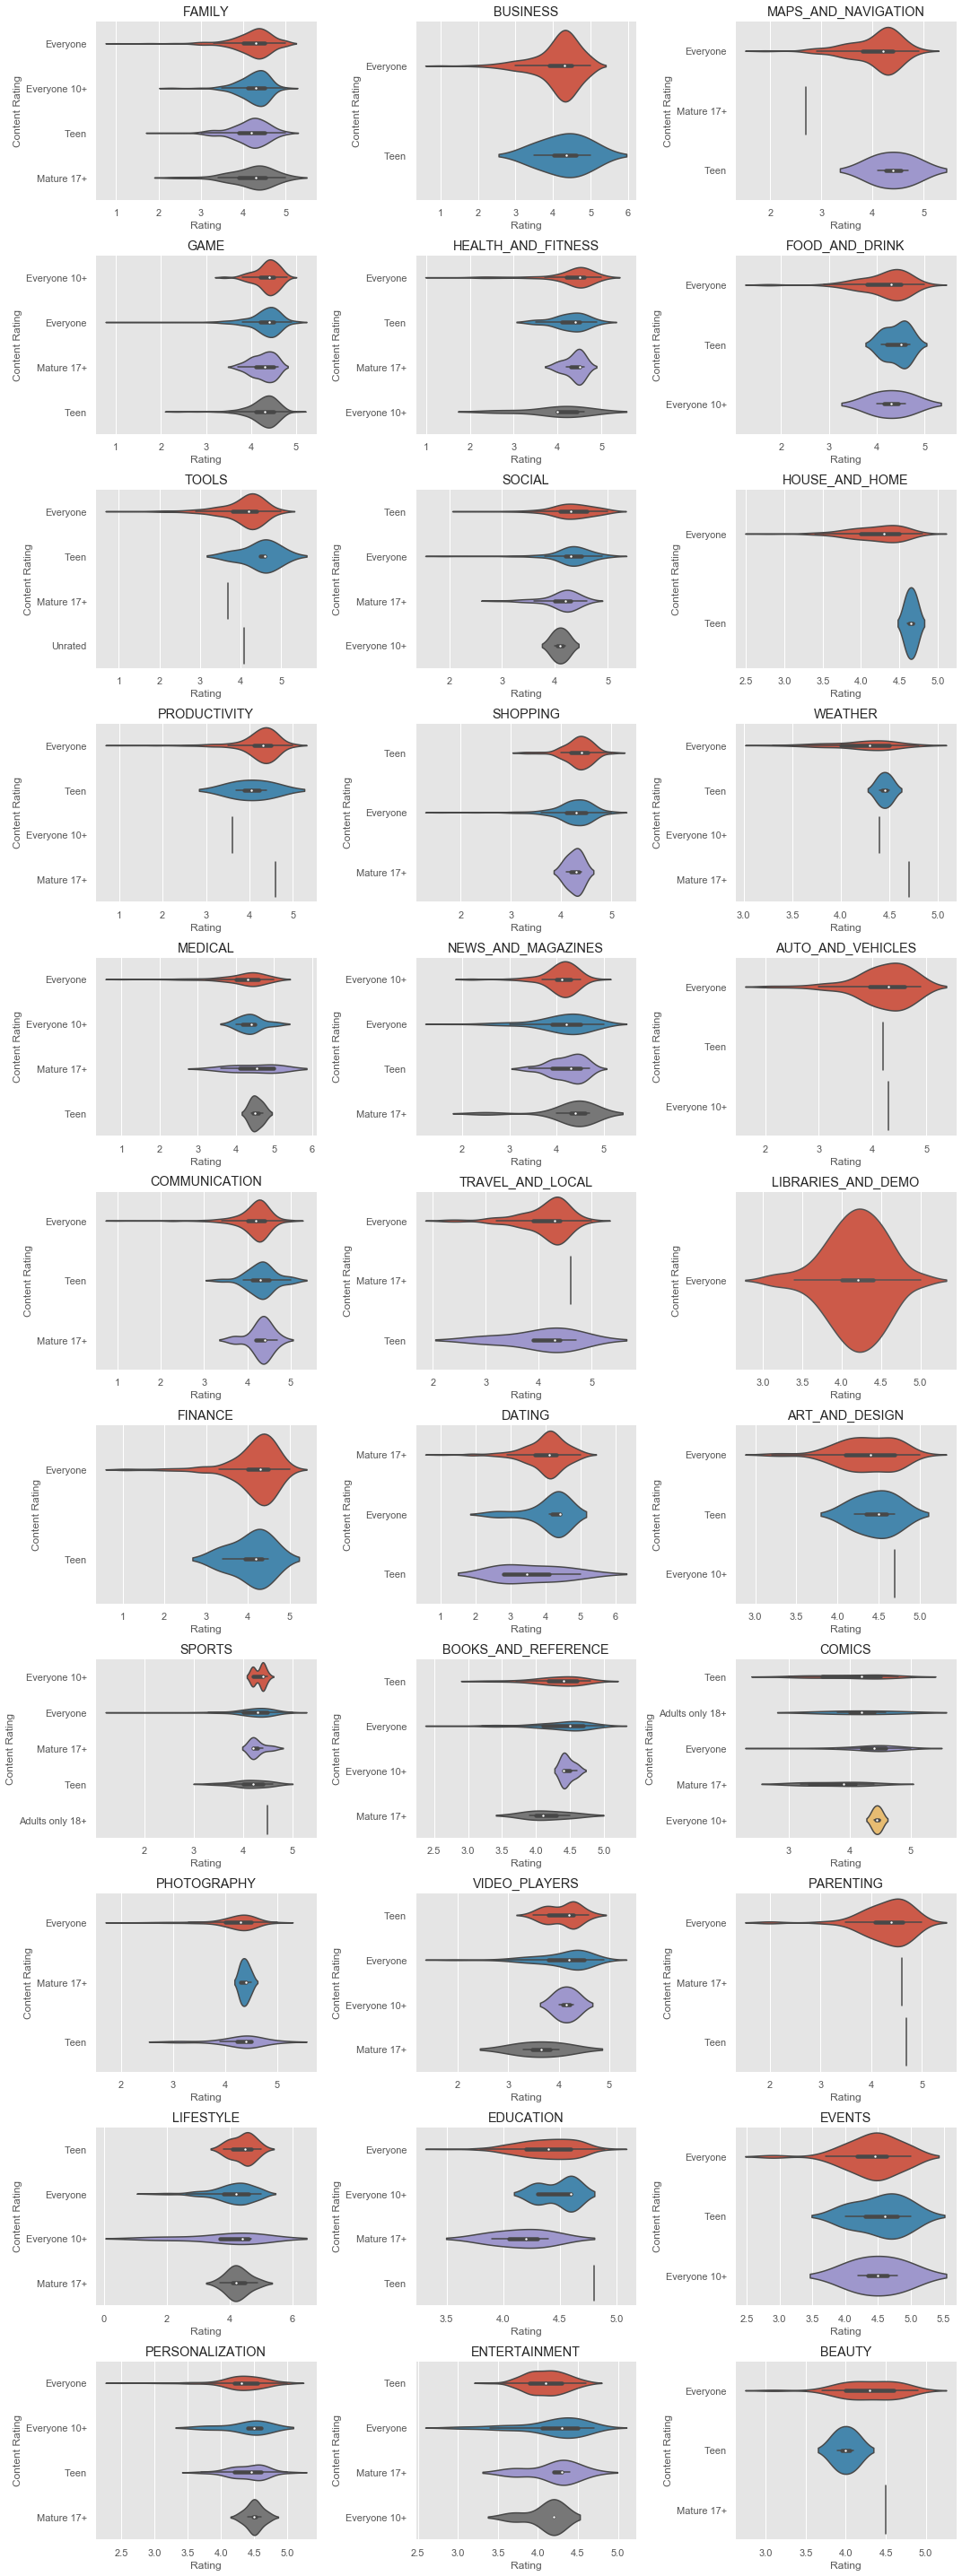

In [74]:
f, ax = plt.subplots(11, 3, figsize=(15, 40))

category = trans_table['Category'].value_counts().index

for i in range(0,33):
    sns.violinplot(x=trans_table[trans_table['Category'] == category[i]]['Rating'], y=trans_table[trans_table['Category'] == category[i]]['Content Rating'] , ax=ax[rowax[i], flat_colax[i]]).set_title(category[i])

plt.tight_layout()
plt.show()

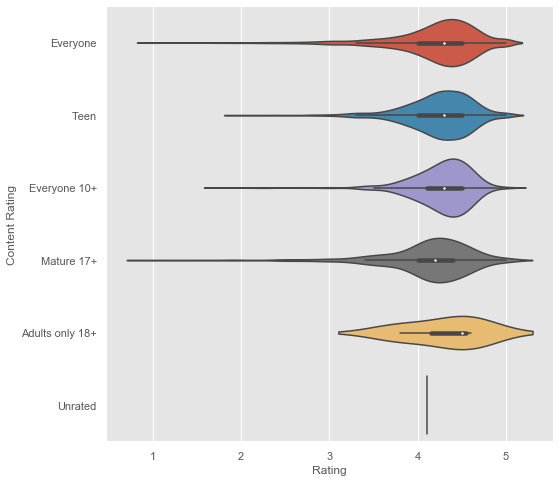

In [75]:
plt.figure(figsize=(8,8))

sns.violinplot(x=table['Rating'], y=table['Content Rating'])

plt.show()

##  NLP - Reviews

In [76]:
# There is not a good way to fill missing data
review = pd.read_csv('googleplaystore_user_reviews.csv')
review = review.dropna()

In [77]:
table_f_cat = pd.read_csv('googleplaystore.csv')

In [78]:
table_f_cat = table_f_cat[['App', 'Category','Rating']]

In [79]:
table_f_cat.head()

App        Category  Rating
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1
1                                Coloring book moana  ART_AND_DESIGN     3.9
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3

In [80]:
review.head()

App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   
5  10 Best Foods for You                                           Best way   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive                1.00                0.533333  
1  Positive                0.25                0.288462  
3  Positive                0.40                0.875000  
4  Positive                1.00                0.300000  
5  Positive                1.00                0.300000

In [81]:
review = review.join(table_f_cat.set_index('App'), on='App')

In [82]:
review.head()

App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
3  10 Best Foods for You         Works great especially going grocery store   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity            Category  \
0  Positive                1.00                0.533333  HEALTH_AND_FITNESS   
0  Positive                1.00                0.533333  HEALTH_AND_FITNESS   
1  Positive                0.25                0.288462  HEALTH_AND_FITNESS   
1  Positive                0.25                0.288462  HEALTH_AND_FITNESS   
3  Positive                0.40                0.875000  HEALTH_AND_FITNESS   

   Rating  
0     4.0  
0     4.0  
1     4.0  
1     4.0  
3     4.0

In [83]:
review = review.drop_duplicates()

In [84]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31189 entries, 0 to 64230
Data columns (total 7 columns):
App                       31189 non-null object
Translated_Review         31189 non-null object
Sentiment                 31189 non-null object
Sentiment_Polarity        31189 non-null float64
Sentiment_Subjectivity    31189 non-null float64
Category                  29747 non-null object
Rating                    29709 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.9+ MB


In [85]:
review = review.dropna()

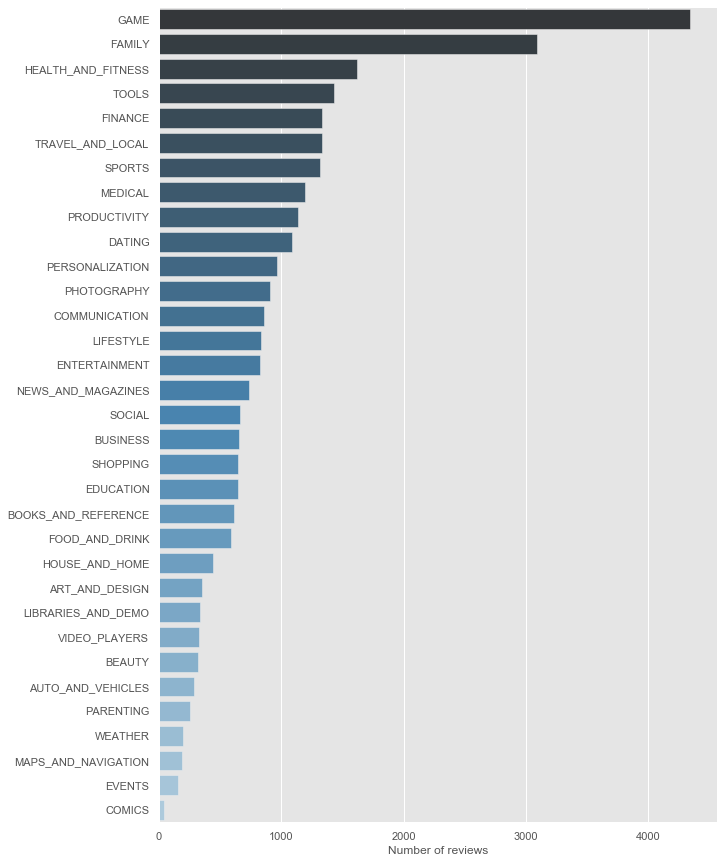

In [86]:
plt.figure(figsize=(10,15))

sns.barplot(x=review['Category'].value_counts(), y=review['Category'].value_counts().index, palette='Blues_d')

plt.xlabel('Number of reviews')
plt.show()

In [87]:
from textblob import TextBlob

In [88]:
TextBlob(review['Translated_Review'][0]).sentiment

Sentiment(polarity=1.0, subjectivity=0.5333333333333333)

In [89]:
review['App'].value_counts()

Episode - Choose Your Story                           248
Colorfy: Coloring Book for Adults - Free              194
Clash Royale                                          192
8 Ball Pool                                           192
Bubble Shooter                                        150
Facebook                                              130
Farm Heroes Saga                                      112
Duolingo: Learn Languages Free                        110
Angry Birds Classic                                   107
Family Locator - GPS Tracker                          105
Flow Free                                             104
Google Photos                                         101
Calorie Counter - Macros                              100
8fit Workouts & Meal Planner                          100
ColorNote Notepad Notes                                99
Calorie Counter - MyFitnessPal                         99
Be A Legend: Soccer                                    98
Adobe Acrobat 

In [90]:
review['Sentiment'].value_counts()

Positive    19049
Negative     6493
Neutral      4167
Name: Sentiment, dtype: int64

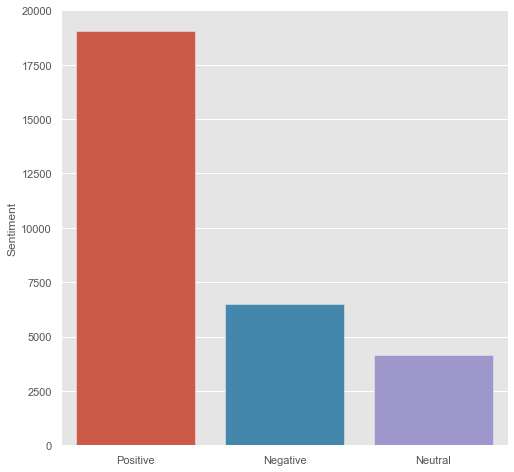

In [91]:
plt.figure(figsize=(8,8))

sns.barplot(review['Sentiment'].value_counts().index, review['Sentiment'].value_counts())

plt.show()

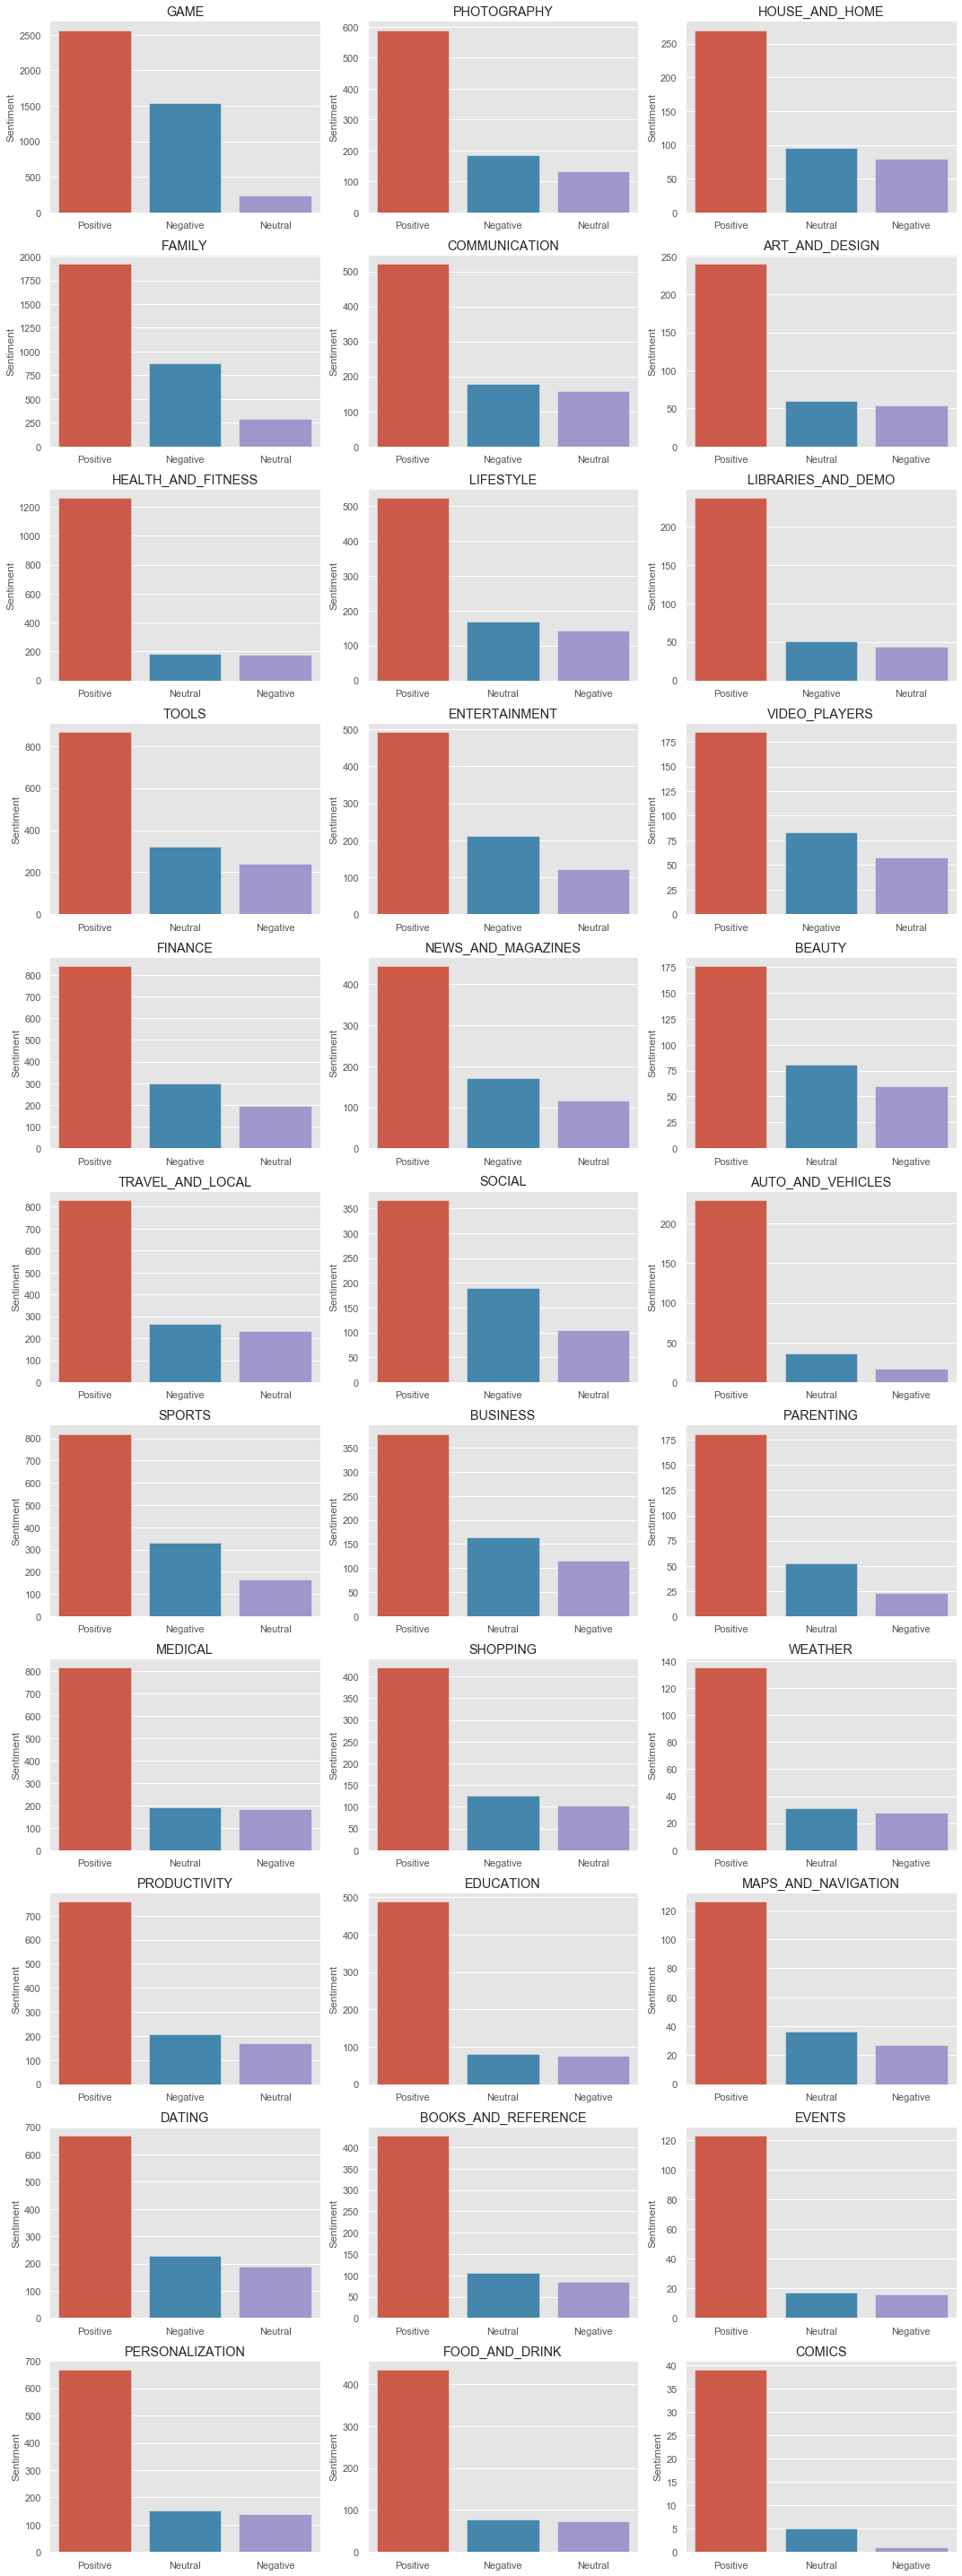

In [92]:
f, ax = plt.subplots(11, 3, figsize=(15, 40))

category = review['Category'].value_counts().index

for i in range(0,33):
    sns.barplot(review[review['Category'] == category[i]]['Sentiment'].value_counts().index, review[review['Category'] == category[i]]['Sentiment'].value_counts(), ax=ax[rowax[i], flat_colax[i]]).set_title(category[i])

plt.tight_layout()
plt.show()

In [93]:
len(review[review['Rating'] >= 4.0])

26303

In [94]:
len(review[review['Rating'] < 4.0])

3406

#### This could mean that people tent to write a positive review when they are satisfy with an application rather than write a negative review on an application.

In [95]:
word_count = []

for i in range(len(review)):
    word_count.append(len(TextBlob(review['Translated_Review'].iloc[i]).words))

In [96]:
review['word_count'] = word_count

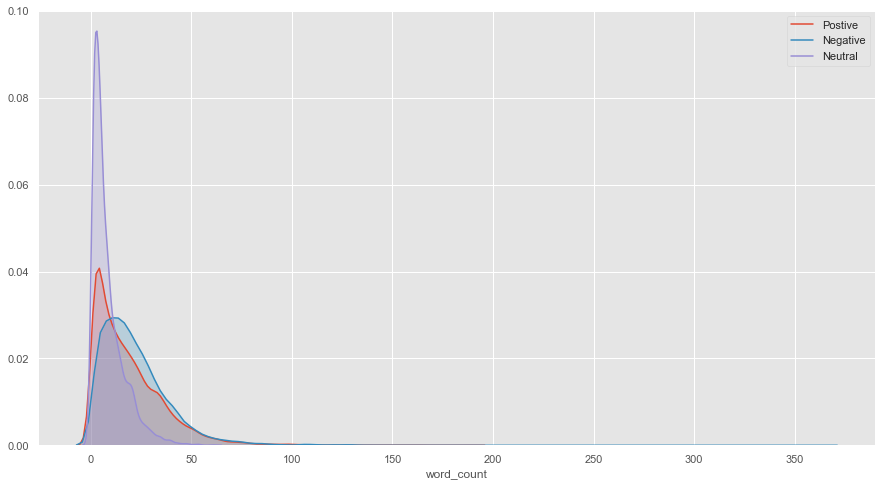

In [97]:
plt.figure(figsize=(15,8))

sns.distplot(review[review['Sentiment'] == 'Positive'].loc[:, 'word_count'], hist=False, kde_kws={'shade':True}, label='Postive')
sns.distplot(review[review['Sentiment'] == 'Negative'].loc[:, 'word_count'], hist=False, kde_kws={'shade':True}, label='Negative')
sns.distplot(review[review['Sentiment'] == 'Neutral'].loc[:, 'word_count'], hist=False, kde_kws={'shade':True}, label='Neutral')

plt.legend()
plt.show()

/Users/hyunilyoo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hyunilyoo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


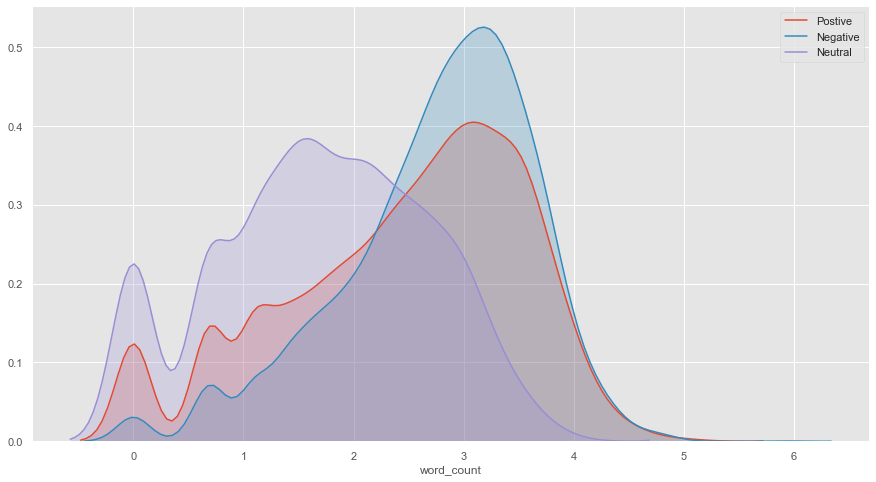

In [98]:
plt.figure(figsize=(15,8))

sns.distplot(np.log(review[review['Sentiment'] == 'Positive'].loc[:, 'word_count']), hist=False, kde_kws={'shade':True}, label='Postive')
sns.distplot(np.log(review[review['Sentiment'] == 'Negative'].loc[:, 'word_count']), hist=False, kde_kws={'shade':True}, label='Negative')
sns.distplot(np.log(review[review['Sentiment'] == 'Neutral'].loc[:, 'word_count']), hist=False, kde_kws={'shade':True}, label='Neutral')

plt.legend()
plt.show()

In [99]:
# Code from https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
# Removing stop words

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [100]:
common_words_positive = get_top_n_words(review[review['Sentiment'] == 'Positive']['Translated_Review'], 20)
positive_words = pd.DataFrame(common_words_positive, columns=['words', 'counts'])

common_words_negative = get_top_n_words(review[review['Sentiment'] == 'Negative']['Translated_Review'], 20)
negative_words = pd.DataFrame(common_words_negative, columns=['words', 'counts'])

common_words_neutral = get_top_n_words(review[review['Sentiment'] == 'Neutral']['Translated_Review'], 20)
neutral_words = pd.DataFrame(common_words_neutral, columns=['words', 'counts'])

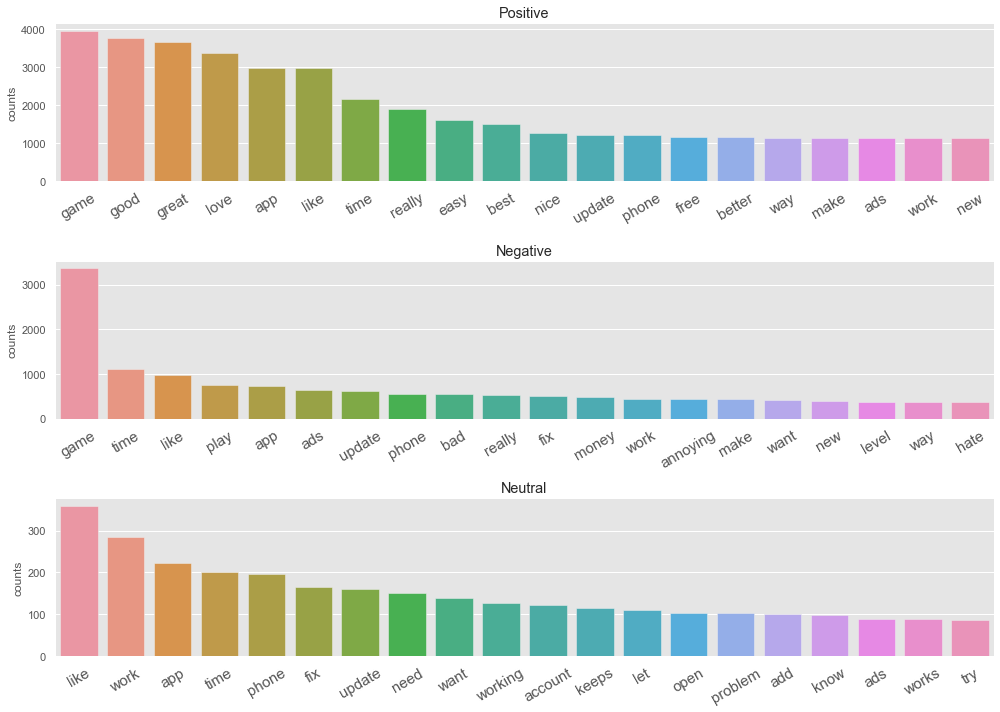

In [101]:
f, ax = plt.subplots(3,1, figsize=(14,10))

ax1 = sns.barplot(x=positive_words['words'], y=positive_words['counts'], ax=ax[0])
ax2 = sns.barplot(x=negative_words['words'], y=negative_words['counts'], ax=ax[1])
ax3 = sns.barplot(x=neutral_words['words'], y=neutral_words['counts'], ax=ax[2])

ax1.tick_params(axis='x', rotation=30, labelsize=15)
ax2.tick_params(axis='x', rotation=30, labelsize=15)
ax3.tick_params(axis='x', rotation=30, labelsize=15)

ax1.set_title('Positive')
ax2.set_title('Negative')
ax3.set_title('Neutral')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.tight_layout()
plt.show()

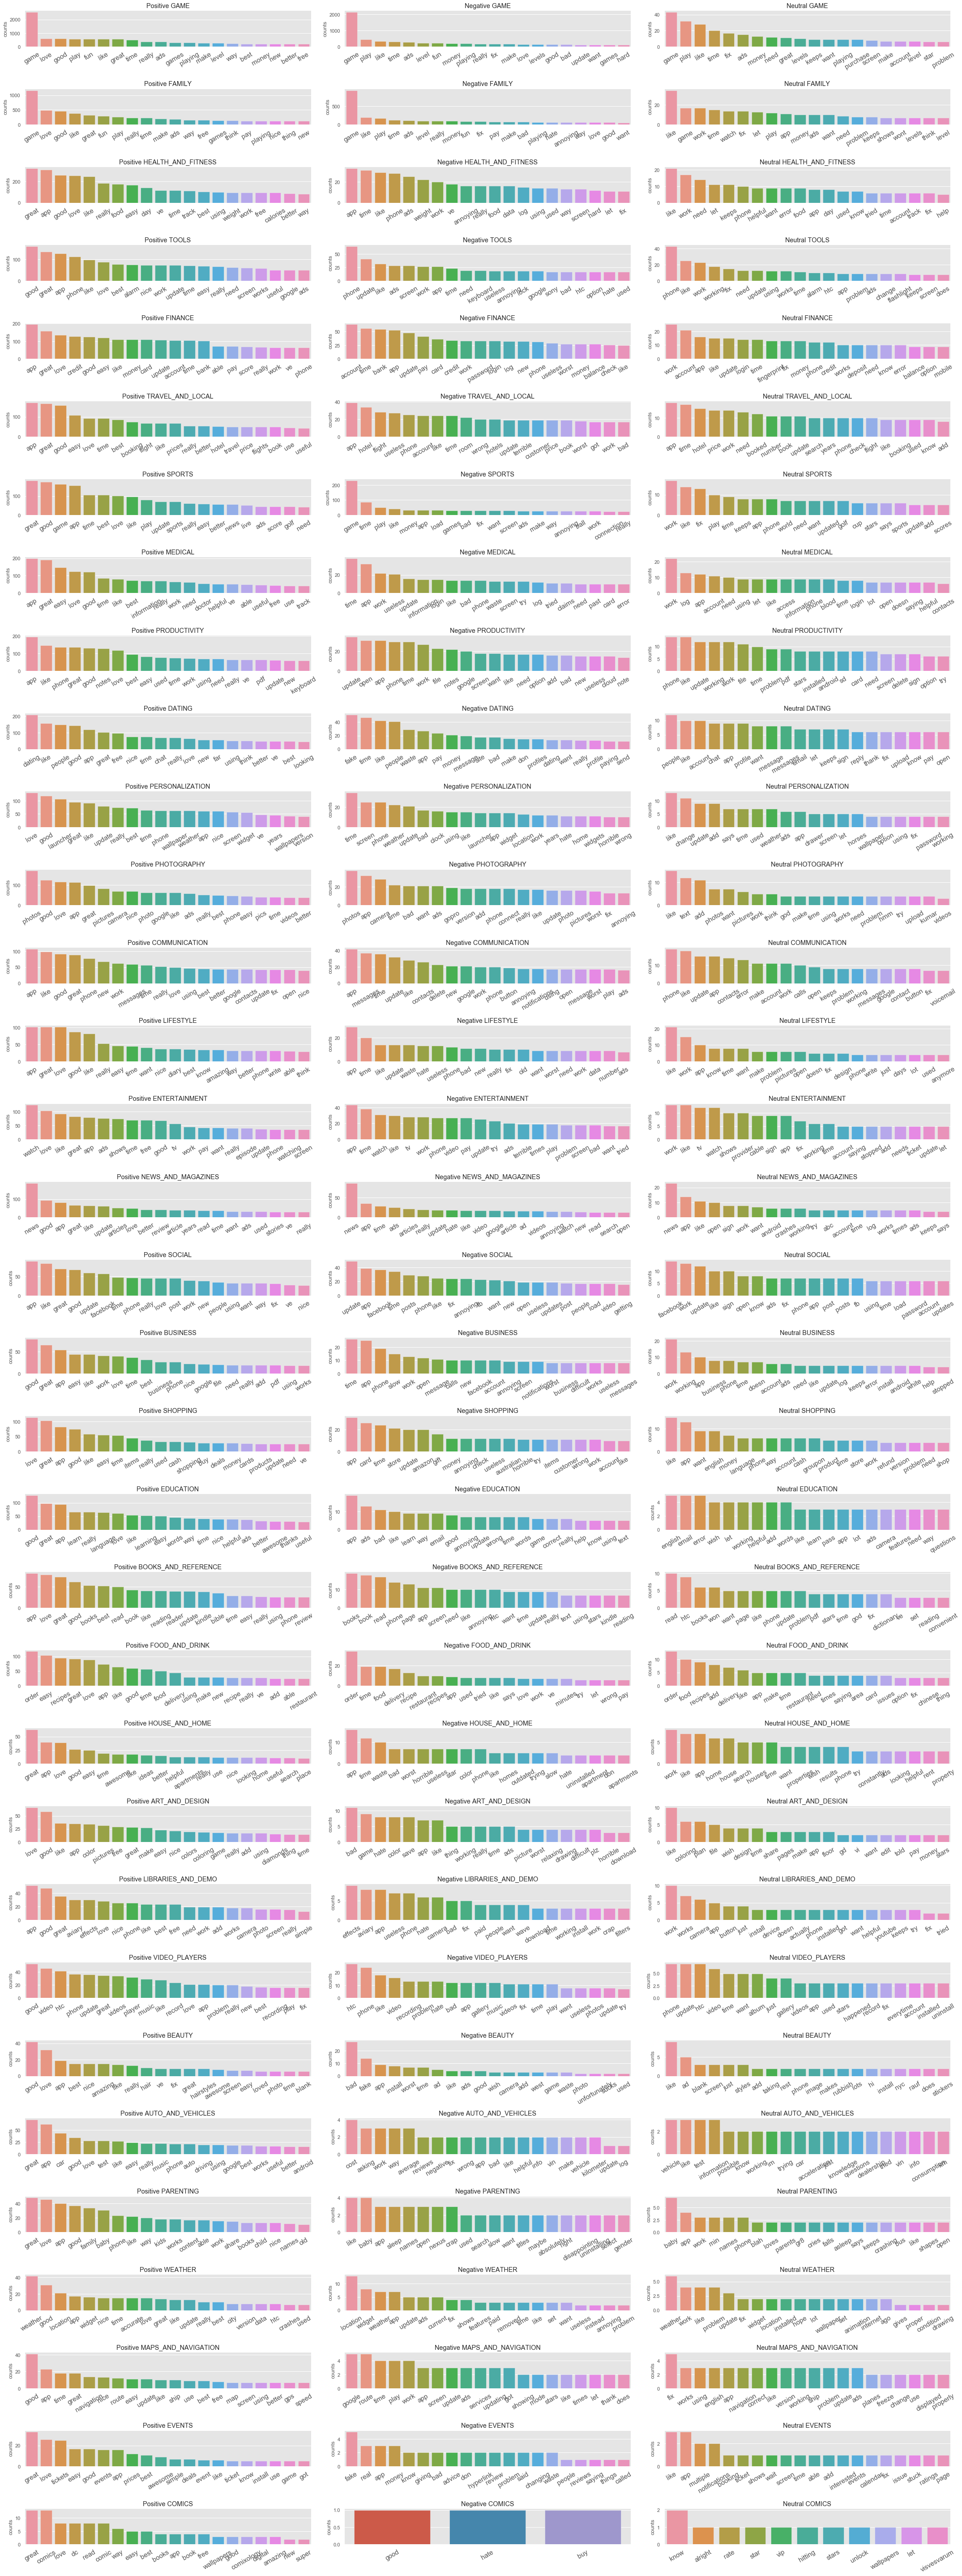

In [102]:
rowax = list(np.arange(0,33))
rowax = rowax * 3

f, ax = plt.subplots(33, 3, figsize=(30, 80))

category = review['Category'].value_counts().index

for i in range(0, 33):
    common_words_positive = get_top_n_words(review[(review['Sentiment'] == 'Positive') & (review['Category'] == category[i])]['Translated_Review'], 20)
    positive_words = pd.DataFrame(common_words_positive, columns=['words', 'counts'])

    common_words_negative = get_top_n_words(review[(review['Sentiment'] == 'Negative') & (review['Category'] == category[i])]['Translated_Review'], 20)
    negative_words = pd.DataFrame(common_words_negative, columns=['words', 'counts'])

    common_words_neutral = get_top_n_words(review[(review['Sentiment'] == 'Neutral') & (review['Category'] == category[i])]['Translated_Review'], 20)
    neutral_words = pd.DataFrame(common_words_neutral, columns=['words', 'counts'])
    
    ax1 = sns.barplot(x=positive_words['words'], y=positive_words['counts'], ax=ax[rowax[i], 0])
    ax2 = sns.barplot(x=negative_words['words'], y=negative_words['counts'], ax=ax[rowax[i], 1])
    ax3 = sns.barplot(x=neutral_words['words'], y=neutral_words['counts'], ax=ax[rowax[i], 2])
    
    ax1.set_title('Positive ' + str(category[i]))
    ax2.set_title('Negative ' + str(category[i]))
    ax3.set_title('Neutral ' + str(category[i]))
    
    ax1.tick_params(axis='x', rotation=30, labelsize=15)
    ax2.tick_params(axis='x', rotation=30, labelsize=15)
    ax3.tick_params(axis='x', rotation=30, labelsize=15)


    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax3.set_xlabel('')

plt.tight_layout()
plt.show()

## Analysis on 'Game'

In [344]:
game = trans_table[trans_table['Category'] == 'GAME']
game_above_4 = trans_table[(trans_table['Rating'] >= 4.0) & (trans_table['Category'] == 'GAME')]
game_below_4 = trans_table[(trans_table['Rating'] < 4.0) & (trans_table['Category'] == 'GAME')]

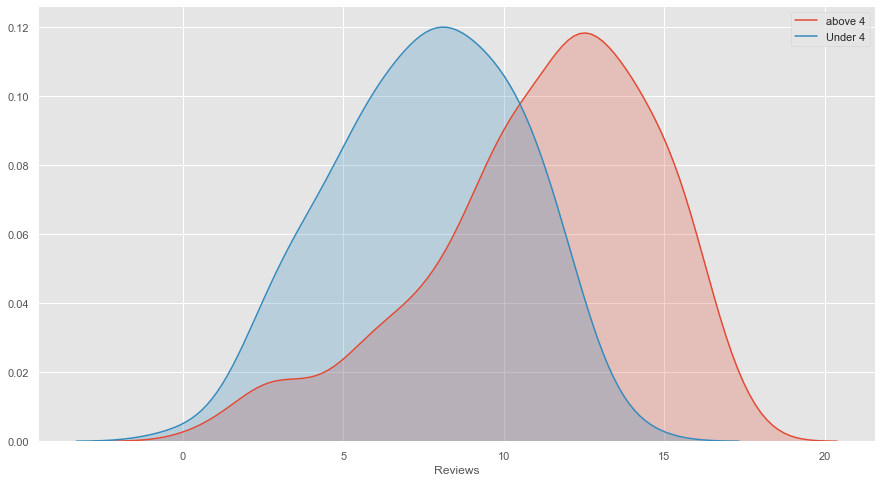

In [343]:
plt.figure(figsize=(15,8))

sns.distplot(game_above_4.loc[:,'Reviews'], hist=False, kde_kws={'shade': True}, label='above 4')
sns.distplot(game_below_4.loc[:,'Reviews'], hist=False, kde_kws={'shade': True}, label='Under 4')

plt.legend()
plt.show()

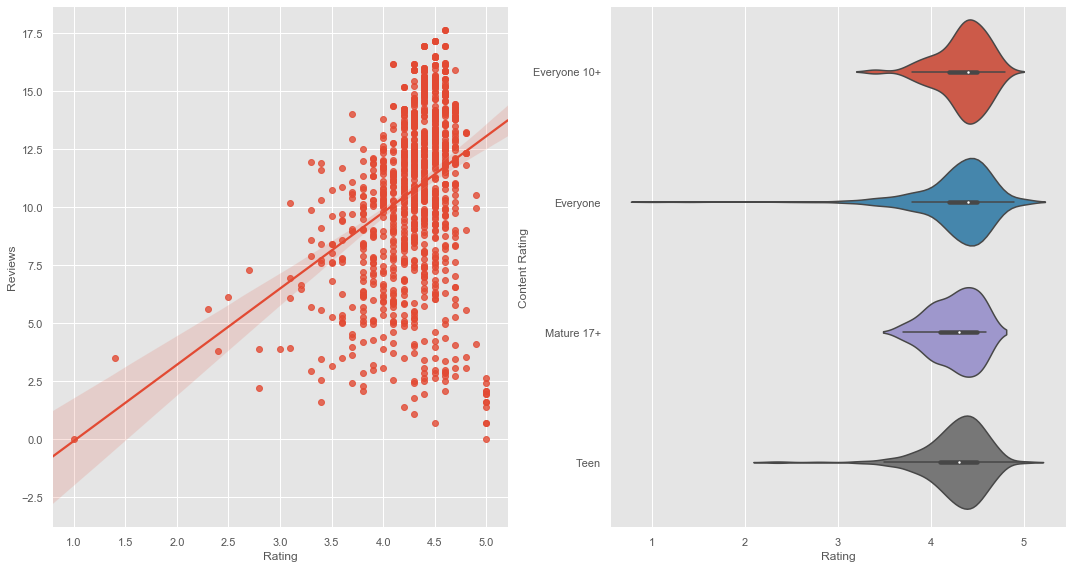

In [367]:
f, ax = plt.subplots(1,2, figsize=(15, 8))

sns.regplot(game['Rating'], game['Reviews'], ax=ax[0])
sns.violinplot(game['Rating'], game['Content Rating'], ax=ax[1])

plt.tight_layout()
plt.show()

In [371]:
game_review = review[review['Category'] == 'GAME']

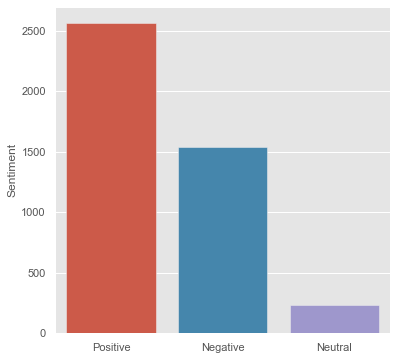

In [378]:
plt.figure(figsize=(6,6))

sns.barplot(game_review['Sentiment'].value_counts().index, game_review['Sentiment'].value_counts())

plt.show()

In [384]:
game_word_count = []

for i in range(len(game_review)):
    game_word_count.append(len(TextBlob(game_review['Translated_Review'].iloc[i]).words))

In [386]:
game_review['word_count'] = game_word_count

/Users/hyunilyoo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


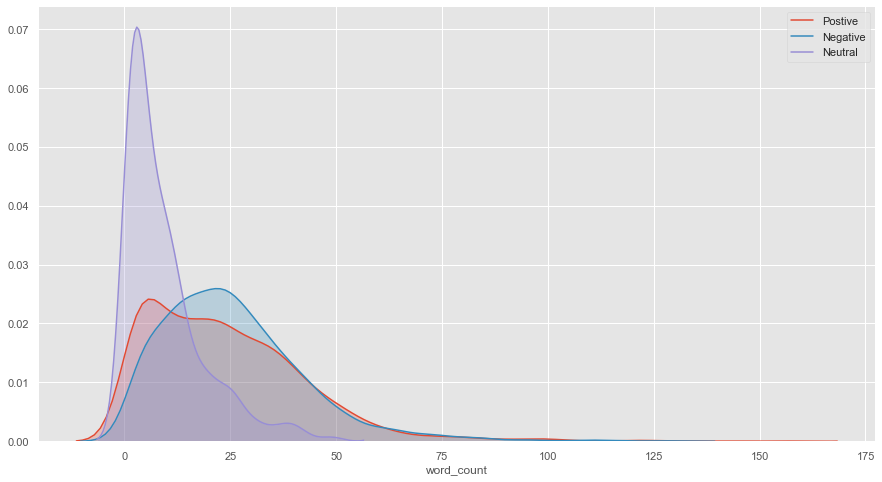

In [391]:
plt.figure(figsize=(15,8))

sns.distplot(game_review[game_review['Sentiment'] == 'Positive'].loc[:, 'word_count'], hist=False, \
             kde_kws={'shade':True}, label='Postive')
sns.distplot(game_review[game_review['Sentiment'] == 'Negative'].loc[:, 'word_count'], hist=False, \
             kde_kws={'shade':True}, label='Negative')
sns.distplot(game_review[game_review['Sentiment'] == 'Neutral'].loc[:, 'word_count'], hist=False, \
             kde_kws={'shade':True}, label='Neutral')

plt.legend()
plt.show()

In [400]:
common_words_positive = get_top_n_words(game_review[game_review['Sentiment'] == 'Positive']['Translated_Review'], 20)
common_words_negative = get_top_n_words(game_review[game_review['Sentiment'] == 'Negative']['Translated_Review'], 20)
common_words_neutral = get_top_n_words(game_review[game_review['Sentiment'] == 'Neutral']['Translated_Review'], 20)

positive_words = pd.DataFrame(common_words_positive, columns=['words', 'counts'])
negative_words = pd.DataFrame(common_words_negative, columns=['words', 'counts'])
neutral_words = pd.DataFrame(common_words_neutral, columns=['words', 'counts'])

# without 'game'
positive_words = positive_words.iloc[1:]
negative_words = negative_words.iloc[1:]
neutral_words = neutral_words.iloc[1:]

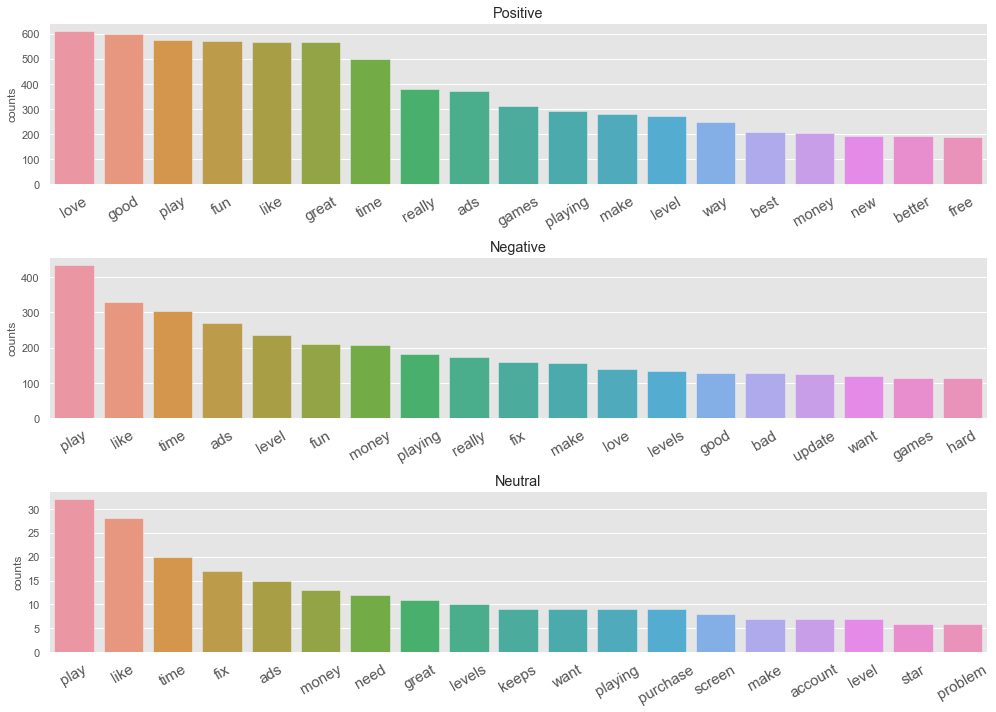

In [401]:
f, ax = plt.subplots(3,1, figsize=(14,10))

ax1 = sns.barplot(x=positive_words['words'], y=positive_words['counts'], ax=ax[0])
ax2 = sns.barplot(x=negative_words['words'], y=negative_words['counts'], ax=ax[1])
ax3 = sns.barplot(x=neutral_words['words'], y=neutral_words['counts'], ax=ax[2])

ax1.tick_params(axis='x', rotation=30, labelsize=15)
ax2.tick_params(axis='x', rotation=30, labelsize=15)
ax3.tick_params(axis='x', rotation=30, labelsize=15)

ax1.set_title('Positive')
ax2.set_title('Negative')
ax3.set_title('Neutral')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.tight_layout()
plt.show()

## ML

In [103]:
trans_table.head()

Category  Rating    Reviews Content Rating  Android Ver
0  ART_AND_DESIGN     4.1   5.068904       Everyone         4.03
1  ART_AND_DESIGN     3.9   6.874198       Everyone         4.03
2  ART_AND_DESIGN     4.7  11.379508       Everyone         4.03
3  ART_AND_DESIGN     4.5  12.281384           Teen         4.20
4  ART_AND_DESIGN     4.3   6.874198       Everyone         4.40

### RBF Kernel

In [276]:
# Data preparation for baseline
baseline_dataset = trans_table.drop(['Android Ver'], axis=1)

# One hot encoding
baseline_dataset = pd.get_dummies(baseline_dataset)

X = baseline_dataset.drop('Rating', axis=1)
y = baseline_dataset.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [277]:
baseline_svr = SVR()
baseline_svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [278]:
# MSE on Training set
mean_squared_error(y_train, baseline_svr.predict(X_train))

0.2532793622244905

In [279]:
# MSE on Test set
mean_squared_error(y_test, baseline_svr.predict(X_test))

0.25615816488117044

In [280]:
b_train_size, b_train_scores_svr, b_test_scores_svr = learning_curve(SVR(), X, y, train_sizes=np.linspace(0.1, 1, 10), scoring='neg_mean_squared_error', cv=10)

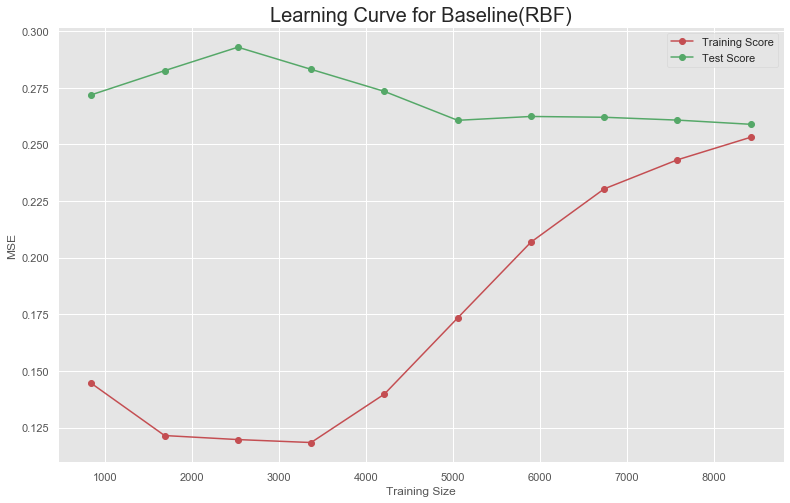

In [281]:
plt.figure(figsize=(13,8))

plt.plot(b_train_size, -b_train_scores_svr.mean(1), 'o-', color='r', label='Training Score')
plt.plot(b_train_size, -b_test_scores_svr.mean(1), 'o-', color='g', label='Test Score')

plt.title('Learning Curve for Baseline(RBF)', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Training Size')
plt.legend()
plt.show()

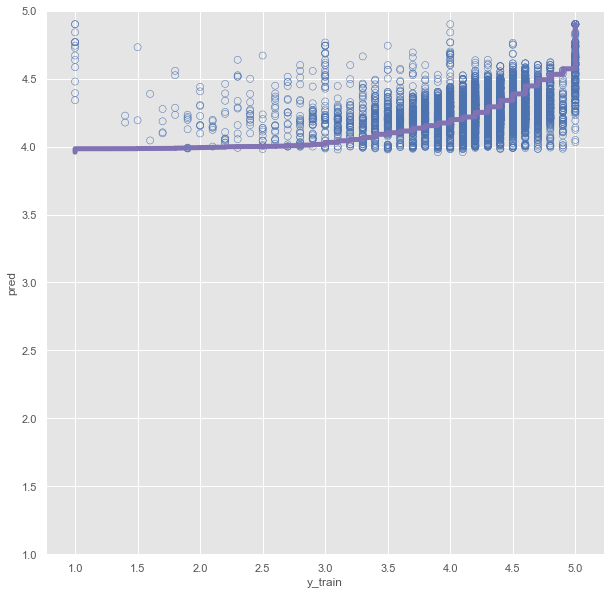

In [282]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_train), np.sort(baseline_svr.predict(X_train)),lw=5, color='m')
plt.scatter(y_train, baseline_svr.predict(X_train), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.xticks(np.arange(1, 5.5, 0.5))
plt.yticks(np.arange(1, 5.5, 0.5))
plt.show()

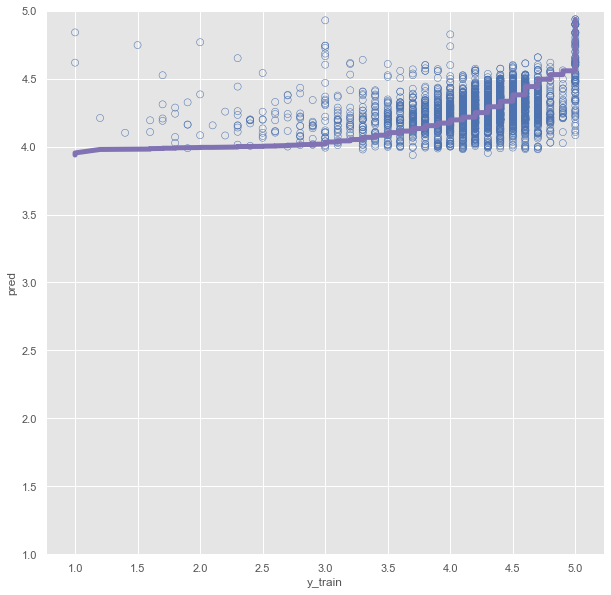

In [283]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_test), np.sort(baseline_svr.predict(X_test)),lw=5, color='m')
#plt.scatter(y_train.iloc[baseline_svr.support_], baseline_svr.predict(X_train)[baseline_svr.support_] , facecolor='none', edgecolor='m', s=30)
plt.scatter(y_test, baseline_svr.predict(X_test), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.xticks(np.arange(1, 5.5, 0.5))
plt.yticks(np.arange(1, 5.5, 0.5))
plt.show()

In [284]:
# Apps that are above Rating 4
len(y_train[y_train >= 4]) /len(y_train)

0.7880683552029295

### Down Sampling

In [309]:
above_4 = baseline_dataset[baseline_dataset['Rating'] >= 4.0]
below_4 = baseline_dataset[baseline_dataset['Rating'] < 4.0] 

In [310]:
len(below_4)

1998

In [311]:
dsample_above_4 = above_4.sample(n=1998, replace=True, random_state=1)
dsample_dataset = below_4.append(dsample_above_4)

In [312]:
X = dsample_dataset.drop('Rating', axis=1)
y = dsample_dataset['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [313]:
baseline_svr_d = SVR()
baseline_svr_d.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [314]:
# MSE on Training set
mean_squared_error(y_train, baseline_svr_d.predict(X_train))

0.3256343963489113

In [315]:
# MSE on Test set
mean_squared_error(y_test, baseline_svr_d.predict(X_test))

0.3789064115521255

In [316]:
b_train_size, b_train_scores_svr, b_test_scores_svr = learning_curve(SVR(), X, y, train_sizes=np.linspace(0.1, 1, 10), scoring='neg_mean_squared_error', cv=10)

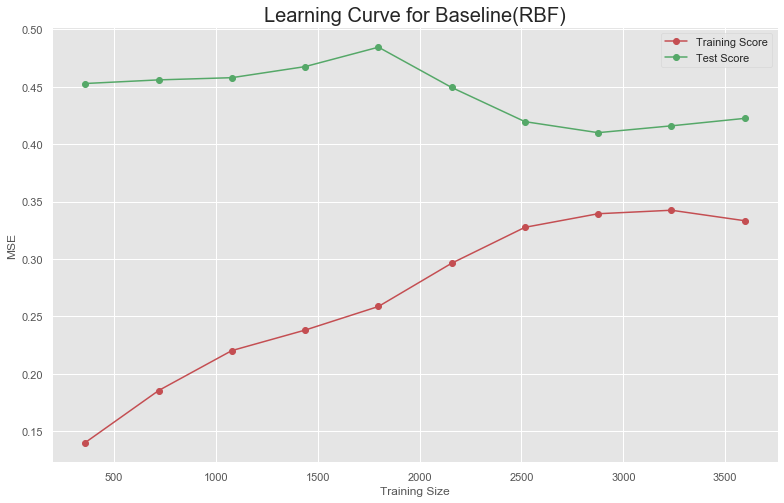

In [317]:
plt.figure(figsize=(13,8))

plt.plot(b_train_size, -b_train_scores_svr.mean(1), 'o-', color='r', label='Training Score')
plt.plot(b_train_size, -b_test_scores_svr.mean(1), 'o-', color='g', label='Test Score')

plt.title('Learning Curve for Baseline(RBF)', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Training Size')
plt.legend()
plt.show()

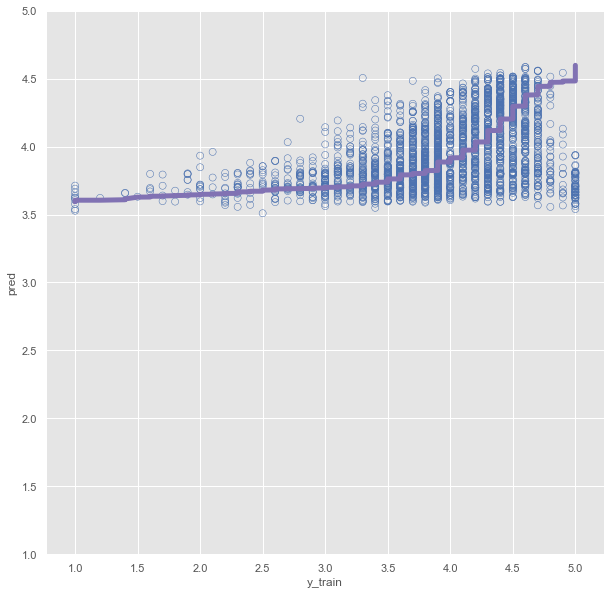

In [318]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_train), np.sort(baseline_svr_d.predict(X_train)),lw=5, color='m')
plt.scatter(y_train, baseline_svr.predict(X_train), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.xticks(np.arange(1, 5.5, 0.5))
plt.yticks(np.arange(1, 5.5, 0.5))
plt.show()

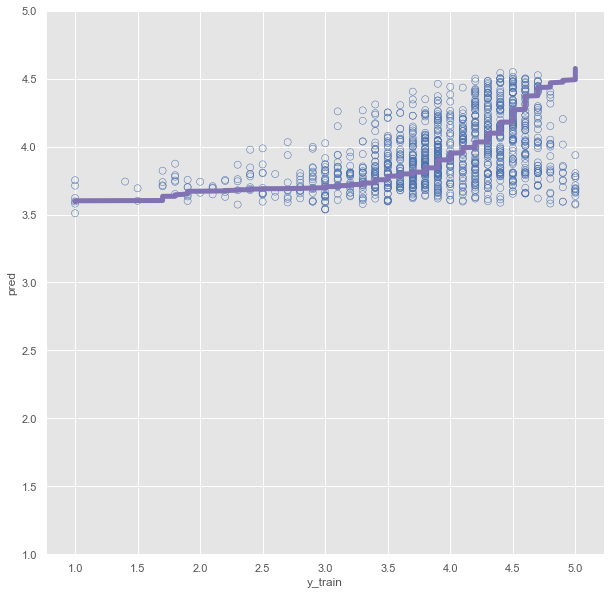

In [319]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_test), np.sort(baseline_svr_d.predict(X_test)),lw=5, color='m')
#plt.scatter(y_train.iloc[baseline_svr.support_], baseline_svr.predict(X_train)[baseline_svr.support_] , facecolor='none', edgecolor='m', s=30)
plt.scatter(y_test, baseline_svr.predict(X_test), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.xticks(np.arange(1, 5.5, 0.5))
plt.yticks(np.arange(1, 5.5, 0.5))
plt.show()

### Over-sampling

In [320]:
len(baseline_dataset)/2

4682.0

In [321]:
osample_above_4 = above_4.sample(n=4682, replace=True, random_state=1)
osample_below_4 = below_4.sample(n=4682, replace=True, random_state=1)

osample_dataset = osample_above_4.append(osample_below_4)

In [322]:
X = osample_dataset.drop('Rating', axis=1)
y = osample_dataset['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [323]:
baseline_svr_o = SVR()
baseline_svr_o.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [324]:
# MSE on Training set
mean_squared_error(y_train, baseline_svr_o.predict(X_train))

0.32636119592506274

In [325]:
# MSE on Test set
mean_squared_error(y_test, baseline_svr_o.predict(X_test))

0.3297115785882375

In [326]:
b_train_size, b_train_scores_svr, b_test_scores_svr = learning_curve(SVR(), X, y, train_sizes=np.linspace(0.1, 1, 10), scoring='neg_mean_squared_error', cv=10)

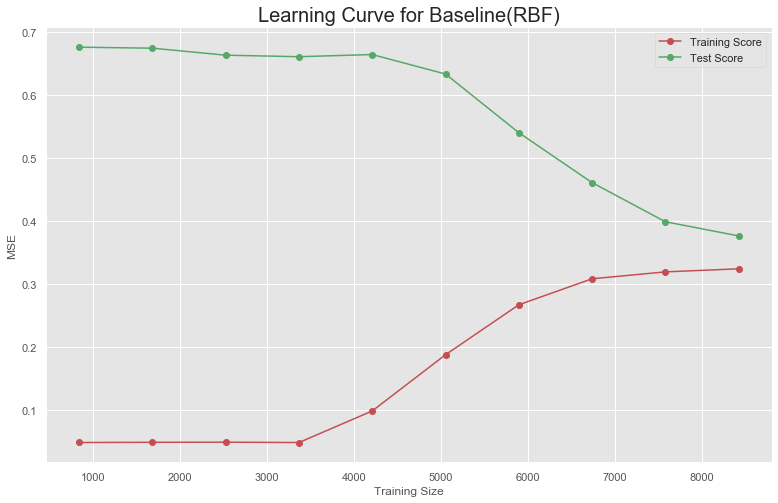

In [327]:
plt.figure(figsize=(13,8))

plt.plot(b_train_size, -b_train_scores_svr.mean(1), 'o-', color='r', label='Training Score')
plt.plot(b_train_size, -b_test_scores_svr.mean(1), 'o-', color='g', label='Test Score')

plt.title('Learning Curve for Baseline(RBF)', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Training Size')
plt.legend()
plt.show()

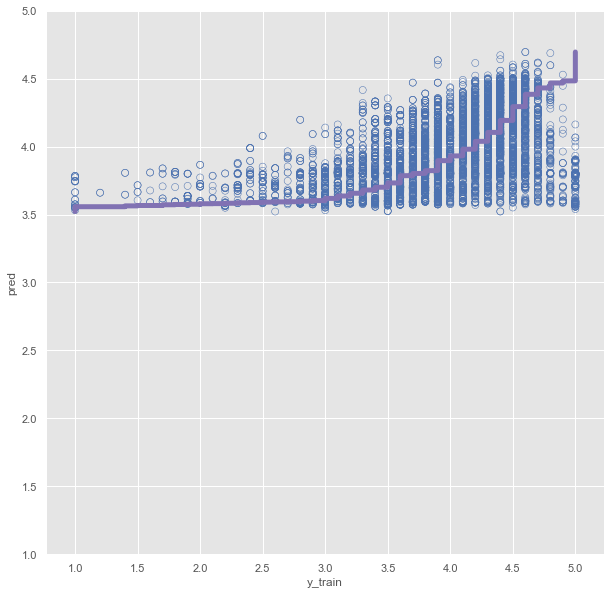

In [328]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_train), np.sort(baseline_svr_o.predict(X_train)),lw=5, color='m')
plt.scatter(y_train, baseline_svr_o.predict(X_train), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.xticks(np.arange(1, 5.5, 0.5))
plt.yticks(np.arange(1, 5.5, 0.5))
plt.show()

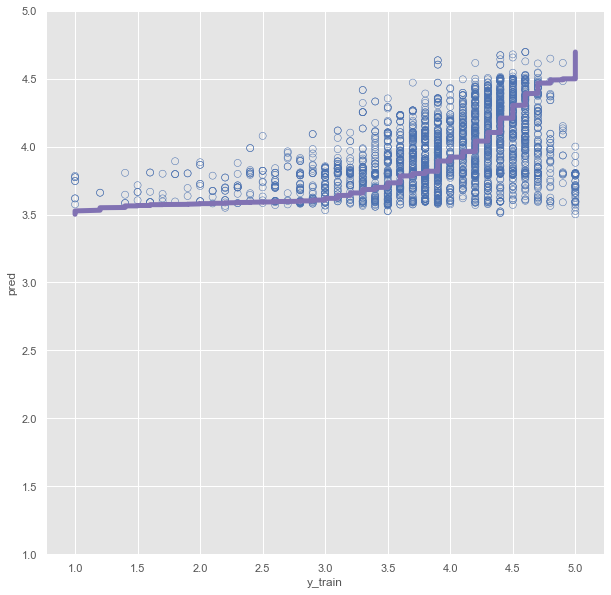

In [329]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_test), np.sort(baseline_svr_o.predict(X_test)),lw=5, color='m')
plt.scatter(y_test, baseline_svr_o.predict(X_test), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.xticks(np.arange(1, 5.5, 0.5))
plt.yticks(np.arange(1, 5.5, 0.5))
plt.show()

### Sampling Test 

In [239]:
testset_1 = above_4.iloc[:1000]
testset_2 = below_4[:1000]

testset = testset_1.append(testset_2)

In [264]:
len(baseline_dataset)/6 #- len(baseline_dataset)

1560.6666666666667

In [287]:
tsample_above_4 = above_4.iloc[1001:].sample(n=1560, replace=True, random_state=1)
tsample_below_4 = below_4.iloc[1001:].sample(n=7803, replace=True, random_state=1)

tsample_dataset = tsample_above_4.append(tsample_below_4)

In [288]:
X = tsample_dataset.drop('Rating', axis=1)
y = tsample_dataset['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [289]:
baseline_svr_st = SVR()
baseline_svr_st.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [290]:
# MSE on Training set
mean_squared_error(y_train, baseline_svr_st.predict(X_train))

0.3236038490879189

In [291]:
# MSE on Test set
mean_squared_error(y_test, baseline_svr_st.predict(X_test))

0.31925965711421983

In [292]:
b_train_size, b_train_scores_svr, b_test_scores_svr = learning_curve(SVR(), X, y, train_sizes=np.linspace(0.1, 1, 10), scoring='neg_mean_squared_error', cv=10)

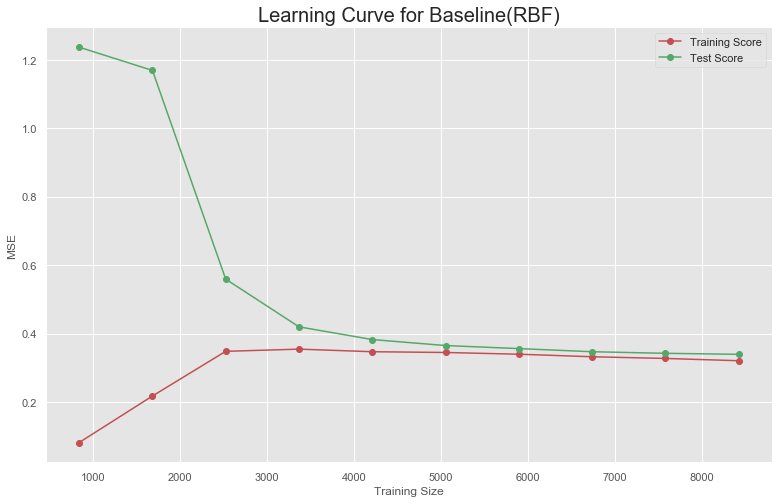

In [293]:
plt.figure(figsize=(13,8))

plt.plot(b_train_size, -b_train_scores_svr.mean(1), 'o-', color='r', label='Training Score')
plt.plot(b_train_size, -b_test_scores_svr.mean(1), 'o-', color='g', label='Test Score')

plt.title('Learning Curve for Baseline(RBF)', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Training Size')
plt.legend()
plt.show()

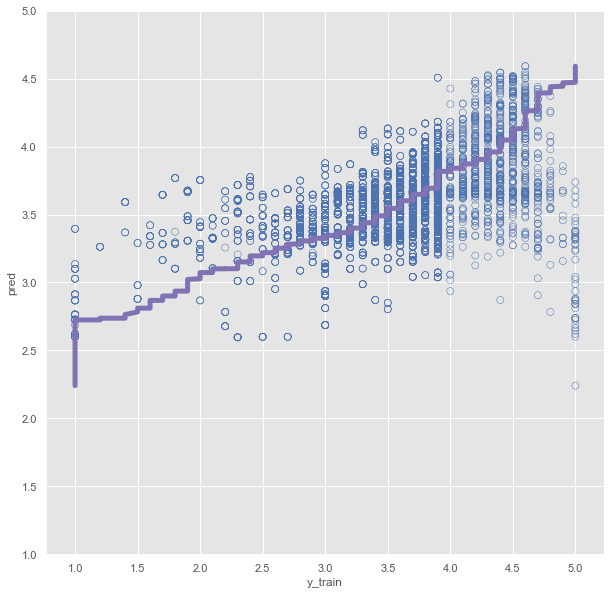

In [294]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_train), np.sort(baseline_svr_st.predict(X_train)),lw=5, color='m')
plt.scatter(y_train, baseline_svr_st.predict(X_train), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.xticks(np.arange(1, 5.5, 0.5))
plt.yticks(np.arange(1, 5.5, 0.5))
plt.show()

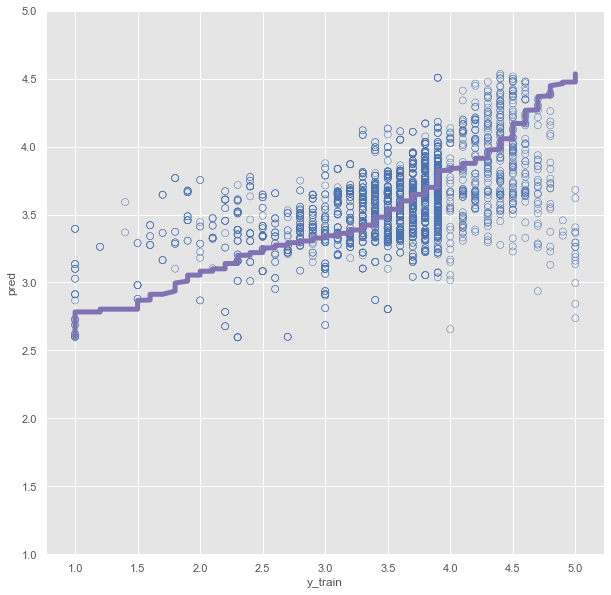

In [295]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_test), np.sort(baseline_svr_st.predict(X_test)),lw=5, color='m')
#plt.scatter(y_train.iloc[baseline_svr.support_], baseline_svr.predict(X_train)[baseline_svr.support_] , facecolor='none', edgecolor='m', s=30)
plt.scatter(y_test, baseline_svr_st.predict(X_test), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.xticks(np.arange(1, 5.5, 0.5))
plt.yticks(np.arange(1, 5.5, 0.5))
plt.show()

### Hyperparameters tuning

In [130]:
# Support Vector Regression
# Hyper parameters for SVR

kernel = ['poly']
degree = [1, 3, 5]
gamma = np.logspace(-2, 2, 5)
c = [1e0, 1e1, 1e2, 1e3]
coef = [0, 1, 2]

svr_grid = {'kernel': kernel, 'degree': degree,'gamma': gamma, 'coef0': coef, 'C': c}

In [ ]:
svreg = SVR()
svr_cv = GridSearchCV(svreg, svr_grid, cv=5)
svr_models = svr_cv.fit(X_train, y_train)

print('Tuned Parameters: {}'.format(svr_models.best_params_), \
      '\n', '\n','Best score is {}'.format(svr_models.best_score_))

In [ ]:
tun_svr_1 = SVR(C=10, gamma=0.01, kernel='rbf')
tun_svr_1.fit(X_train, y_train)

In [ ]:
# MSE on Training set
print('MSE on Training: ',mean_squared_error(y_train, tun_svr_1.predict(X_train)))

In [ ]:
# MSE on Test set
mean_squared_error(y_test, tun_svr_1.predict(X_test))

In [ ]:
t_train_size, t_train_scores_svr, t_test_scores_svr = learning_curve(SVR(C=10, gamma=0.01, kernel='rbf'), X, y, train_sizes=np.linspace(0.1, 1, 10), scoring='neg_mean_squared_error', cv=10)

In [ ]:
plt.figure(figsize=(13,8))

plt.plot(t_train_size, -t_train_scores_svr.mean(1), 'o-', color='r', label='Training Score')
plt.plot(t_train_size, -t_test_scores_svr.mean(1), 'o-', color='g', label='Test Score')

plt.title('Learning Curve for Baseline', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Training Size')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_train), np.sort(tun_svr_1.predict(X_train)),lw=5, color='m')
#plt.scatter(y_train.iloc[baseline_svr.support_], baseline_svr.predict(X_train)[baseline_svr.support_] , facecolor='none', edgecolor='m', s=30)
plt.scatter(y_train, tun_svr_1.predict(X_train), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(np.sort(y_test), np.sort(tun_svr_1.predict(X_test)),lw=5, color='m')
#plt.scatter(y_train.iloc[baseline_svr.support_], baseline_svr.predict(X_train)[baseline_svr.support_] , facecolor='none', edgecolor='m', s=30)
plt.scatter(y_test, tun_svr_1.predict(X_test), facecolor='none', edgecolor='b', s=50)


plt.xlabel('y_train')
plt.ylabel('pred')
plt.show()